# reach_analysis_A.ipynb

Learn to reach, perform radial reaches, and do the analyses that concern the characteristics of the reach.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter
import pickle

In [3]:
# load a parameter configuration
fname = '/home/z/Dropbox (OIST)/saves/gene_2021-07-19'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

In [4]:
# Configure the simulation
np.random.seed(123456) # always the same random values
#np.random.seed() # arbitrary random seed

cfg = pop[0] # parameter configuration to use

n_reaches_l = 16 # number of targets presented for initial learning
use_syne = False # whether to use the version of the network with "synergies"
set_C_delay = False # whether set C_cid using analytical approach
rand_targets = True # whether to train using a large number of random targets
C_noise = True # whether C units are noisy (use euler_maru integrator)
M__C_rand_w = True # whether to randomly intialize weights for the M__C connections
permute_targets = True # whether to permut target order during radial reaches
t_pres_l = cfg['t_pres'] # target presentation time during initial learning
par_heter = cfg['par_heter']
M_size = 12 # number of units in the M population
SPF_size = 12 # number of units in the SPF population
r = .1 # distance from target to center during radial reaching
t_pres = 6. # new presentation time for radial reaching
n_trgs = 8 # number of targets for radial reaching
n_rounds = 6 # number of times the n_trgs targets will be presented

ad = {'new_noise': 0.,
      'new_gain': 1.2 }

In [5]:
cfg

{'A__M_lrate': 20.0,
 'A__M_w_max_frac': 0.3416925414246987,
 'A__M_w_sum': 1.0,
 'AL_thresh': 0.5646832304372332,
 'b_e': 1.005382808781567,
 'C__C_antag': 1.6082125135964376,
 'C__C_p_antag': 0.14752433979963778,
 'C__C_p_syne': 0.2619884102818456,
 'C__C_syne': 1.0753701617574094,
 'C_adapt_amp': 0.0,
 'C_cid': 0.16543197934780987,
 'C_sigma': 0.5246231087281753,
 'C_slope': 2.2479341885068975,
 'C_tau': 0.23796688582108708,
 'C_tau_slow': 2.0,
 'C_thresh': 1.1368068957249036,
 'CE__CI_w': 0.394921026859755,
 'CI__CE_w': -1.8377885280684836,
 'g_e_03': 20.6142960922296,
 'CI_slope': 3.8942982272628557,
 'CI_tau': 0.05983215510291789,
 'CI_thresh': 1.3749626453609871,
 'g_e_factor': 3.0357748997538976,
 'II_g_03': 2.729430094861937,
 'M__C_lrate': 500.0,
 'M__C_w_sum': 3.276004745823039,
 'M__M_w': 0.0,
 'M_cid': 1.0444156507039333,
 'M_des_out_w_abs_sum': 1.8691951914183804,
 'M_tau': 0.012033751301651956,
 'SF_thresh_03': 0.59118534282718,
 'SPF__SPF_w': -1.6494233616141516,
 'fitn

In [6]:
# Configure the simulation with a result from reach_analysis_B

# load a simulation configuration
fname = '/home/z/Dropbox (OIST)/saves/reach_anaB_2021-07-08'
with (open(fname, "rb")) as f:
    all_results = pickle.load(f)
    f.close()
    
r_num = 210
ad = all_results[r_num]['arg_dict']
cfg = ad['cfg']

n_reaches_l = ad['n_reaches_l'] # number of targets presented for initial learning
use_syne = ad['use_syne'] # whether to use the version of the network with "synergies"
set_C_delay = ad['set_C_delay'] # whether set C_cid using analytical approach
rand_targets = ad['rand_targets'] # whether to train using a large number of random targets
C_noise = ad['C_noise'] # whether C units are noisy (use euler_maru integrator)
M__C_rand_w = ad['M__C_rand_w'] # whether to randomly intialize weights for the M__C connections
permute_targets = ad['permute_targets'] # whether to permut target order during radial reaches
t_pres_l = cfg['t_pres'] # target presentation time during initial learning
par_heter = cfg['par_heter']
M_size = 12 # number of units in the M population
SPF_size = 12 # number of units in the SPF population
r = ad['r'] # distance from target to center during radial reaching
t_pres = ad['t_pres'] # new presentation time for radial reaching
n_trgs = 8 # number of targets for radial reaching
n_rounds = ad['n_rounds'] # number of times the n_trgs targets will be presented

print(" use_syne = %r,\t gain = %.1f,\t noise=%.1f,\t r=%.1f,\t error_r=%.3f" % 
          (ad['use_syne'], ad['new_gain'], ad['new_noise'], ad['r'],  all_results[r_num]['error_r']))

 use_syne = False,	 gain = 1.0,	 noise=0.0,	 r=0.1,	 error_r=0.043


In [6]:
# Create the network
%cd /home/z/projects/draculab/notebook/spinal/
from v3ft3p2ph2_net import *
%cd ../..

if not use_syne:
    net, pops_dict, hand_coords, m_idxs, pds = net_from_cfg(cfg,
                                                       t_pres = t_pres_l,
                                                       par_heter = par_heter,
                                                       set_C_delay = set_C_delay,
                                                       rand_targets = rand_targets,
                                                       track_weights = True,
                                                       track_ips = True,
                                                       C_noise = C_noise,
                                                       M__C_rand_w = M__C_rand_w)
else:
    net, pops_dict, hand_coords, m_idxs, pds = syne_net(cfg,
                                                   t_pres = t_pres,
                                                   par_heter = par_heter,
                                                   set_C_delay = set_C_delay,
                                                   rand_targets = rand_targets,
                                                   track_weights = True,
                                                   track_ips = True,
                                                   C_noise = C_noise,
                                                   M__C_rand_w = M__C_rand_w)

for name in pops_dict:
    exec("%s = %s"% (name, str(pops_dict[name])))

# parameter dictionaries used to change targets
P__A_syn = pds['P__A_syn']
P__A_ws = np.array(P__A_syn['init_w'][12:18])
A__SF_syn = pds['A__SF_syn']
SF_params = pds['SF_params']

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [7]:
# Run simulation for initial learning
sim_time_l = t_pres_l * n_reaches_l
start_wctime = time.time()
times_l, data_l, plant_data_l  = net.flat_run(sim_time_l)

data_l = np.array(data_l)
print('Execution time is %s seconds' % (time.time() - start_wctime))

Execution time is 1189.512068271637 seconds


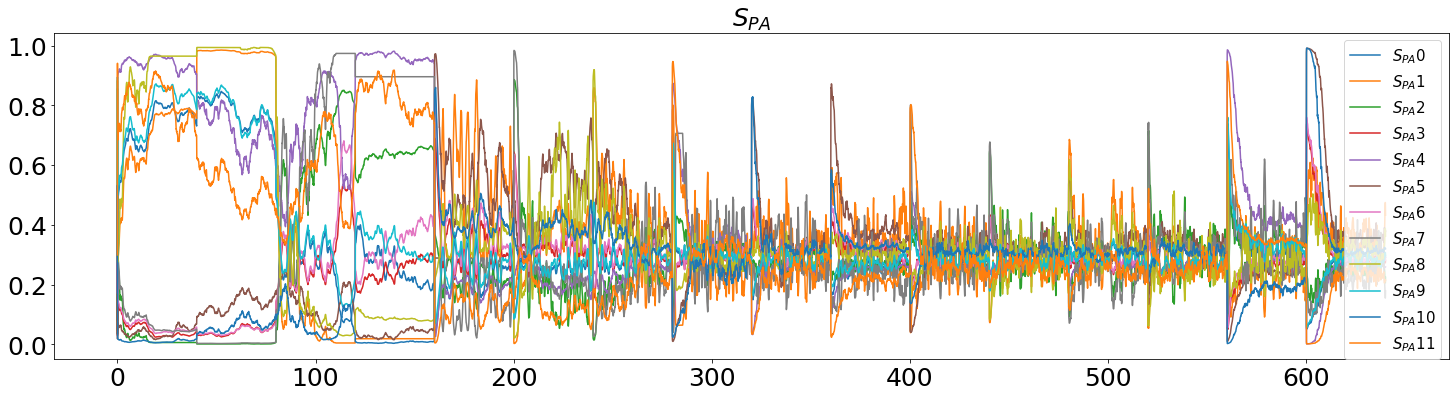

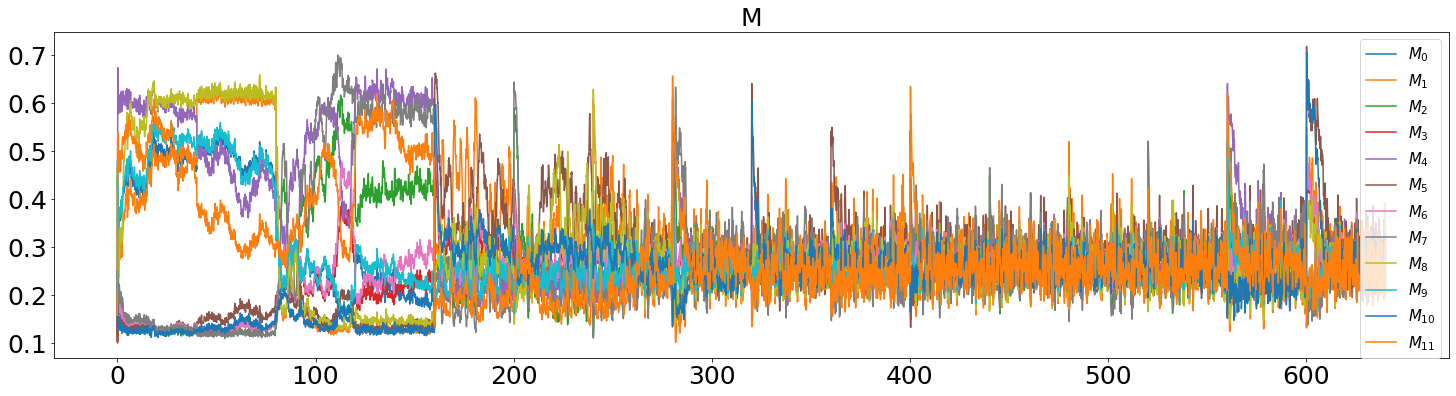

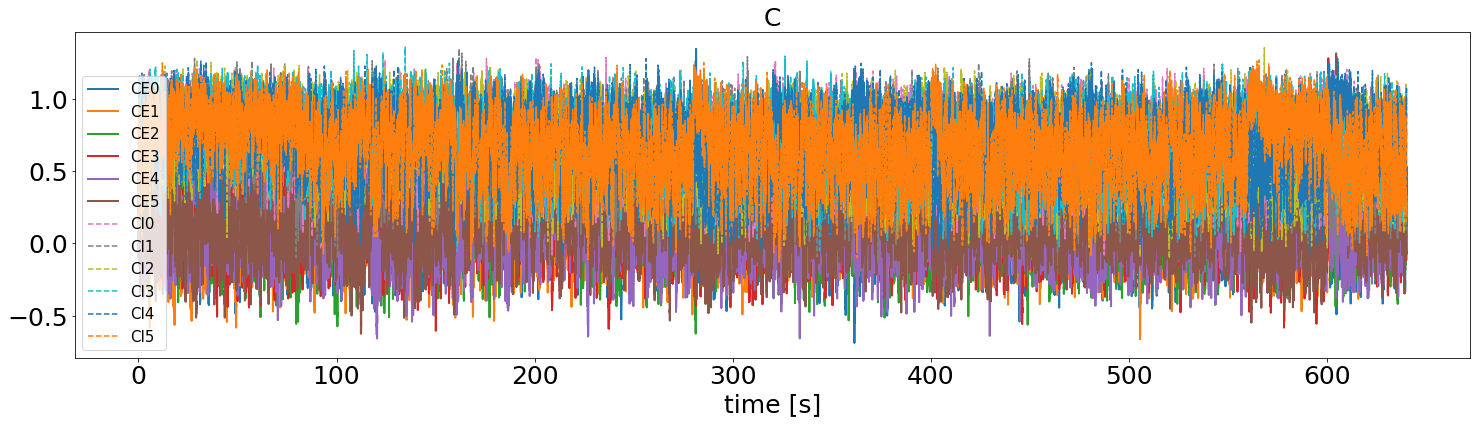

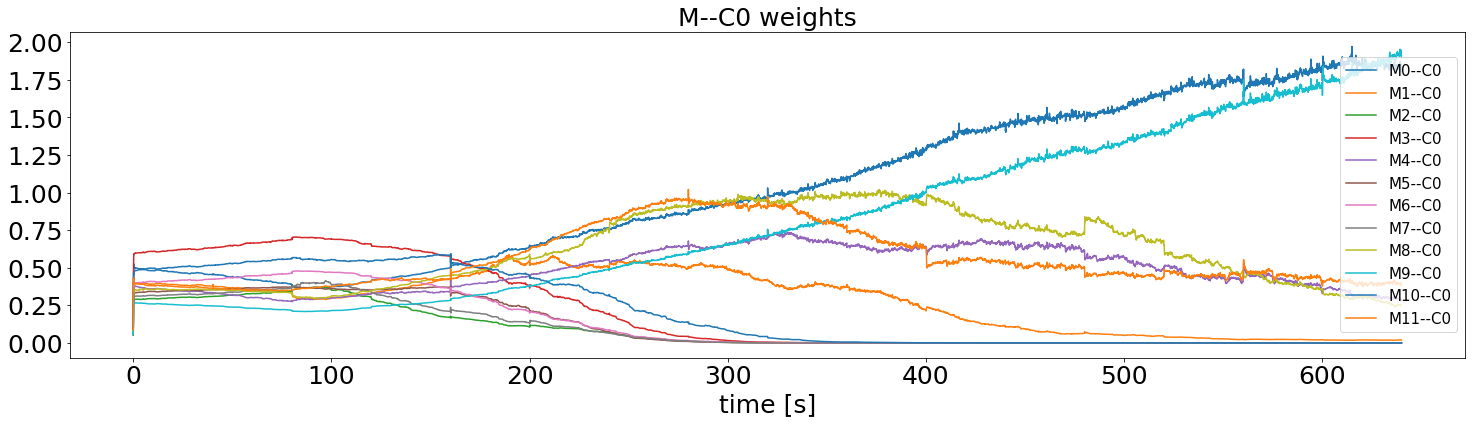

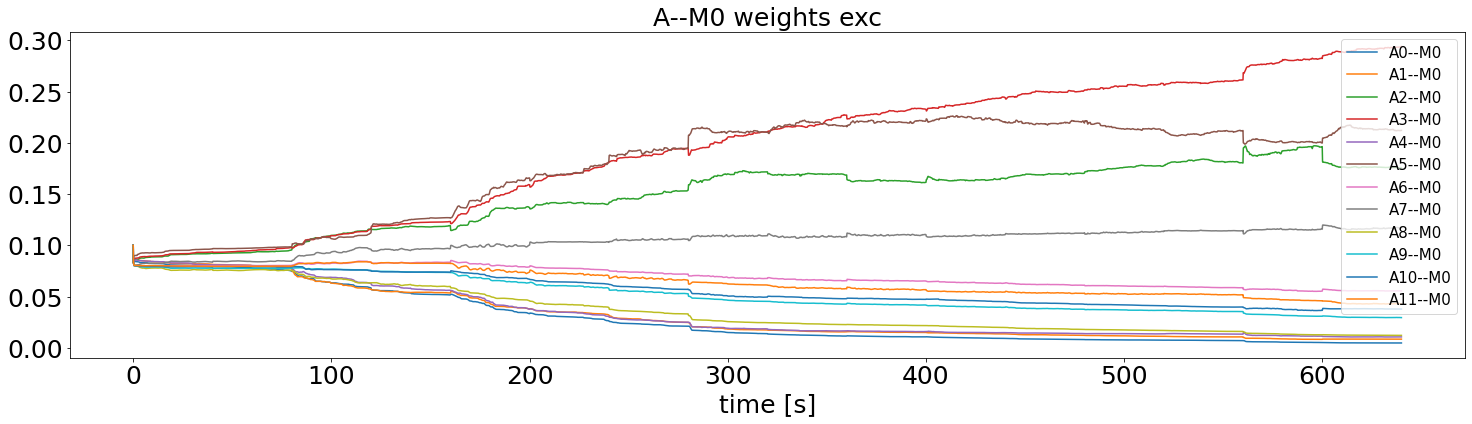

In [8]:
# Produce figures

tic_s = 25 # tick label size
tit_s = 25 # title size
leg_s = 15 # legend text size
lab_s = 25 # axis label font size
arm_activs = plant_data_l[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_ax = plt.gca()
SPF_ax.tick_params(axis='both', labelsize=tic_s)
SPF_data_l = np.array(data_l[SPF])
plt.plot(times_l, SPF_data_l.transpose())
SPF_legends = ['$S_{PA}$'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends, fontsize=15)
plt.title('$S_{PA}$', fontsize=tit_s)

# M
M_fig = plt.figure(figsize=fs)
M_data_l = np.array(data_l[M])
plt.plot(times_l, M_data_l.transpose())
M_legends = ['$M_{'+str(i)+'}$' for i in range(len(M))]
plt.legend(M_legends, fontsize=15)
plt.title('M', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

if use_syne:
    # SYNE, SYNI
    n_syn_f = 4 # how many unit pairs to plot
    SYN_fig = plt.figure(figsize=fs)
    SYNE_data_l = np.array(data_l[SYNE[:n_syn_f]])
    SYNI_data_l = np.array(data_l[SYNI[:n_syn_f]])
    plt.plot(times_l, SYNE_data_l.transpose(), linewidth=2)
    plt.plot(times_l, SYNI_data_l.transpose(), '--')
    SYN_legends = ['SYNE'+str(i) for i in range(n_syn_f)]
    SYN_legends += ['SYNI'+str(i) for i in range(n_syn_f)]
    plt.legend(SYN_legends, fontsize=leg_s)
    plt.title('SYN', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)
    
    # M--SYNE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data_l = np.array(data_l[M_SYNE0_track])
    plt.plot(times_l, w_track_data_l.transpose())
    M_SYNE0_legends = ['M'+str(i)+'--SYNE0' for i in range(len(M_SYNE0_track))]
    plt.legend(M_SYNE0_legends)
    plt.title('M--SYNE0 weights', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tit_s)
else:
    # C
    C_fig = plt.figure(figsize=fs)
    CE_data_l = np.array(data_l[CE])
    CI_data_l = np.array(data_l[CI])
    plt.plot(times_l, CE_data_l.transpose(), linewidth=2)
    plt.plot(times_l, CI_data_l.transpose(), '--')
    C_legends = ['CE'+str(i) for i in range(len(CE))]
    C_legends += ['CI'+str(i) for i in range(len(CI))]
    plt.legend(C_legends, fontsize=leg_s)
    plt.title('C', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

    # M--CE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data_l = np.array(data_l[M_CE0_track])
    plt.plot(times_l, w_track_data_l.transpose())
    M_CE0_legends = ['M'+str(i)+'--C0' for i in range(len(M_CE0_track))]
    plt.legend(M_CE0_legends, fontsize=15)
    plt.title('M--C0 weights', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2_l = np.array(data_l[A_M0_track[0:18]])
plt.plot(times_l, w_track_data2_l.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends, fontsize=15)
plt.title('A--M0 weights exc', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

plt.show()

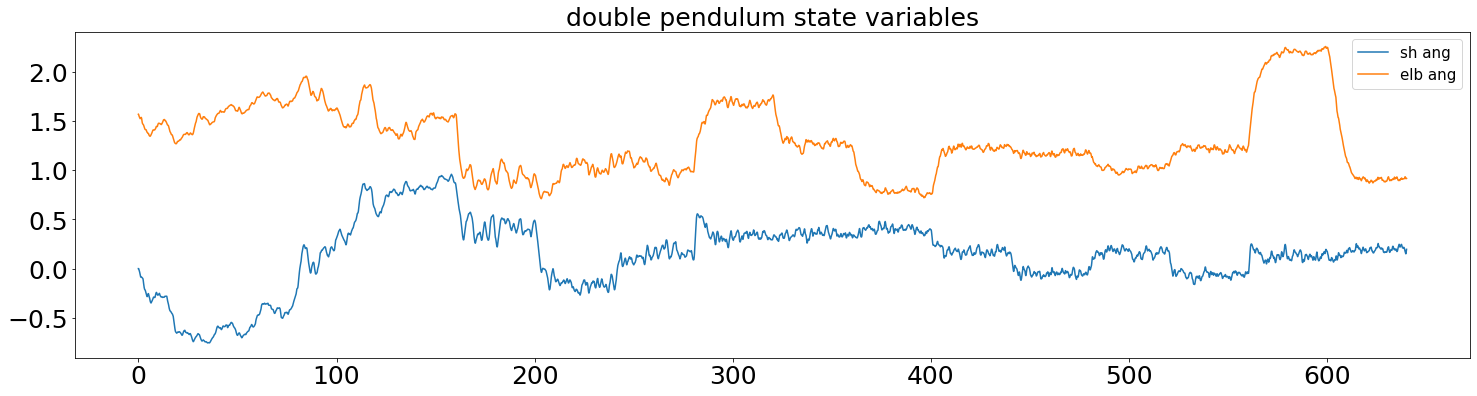

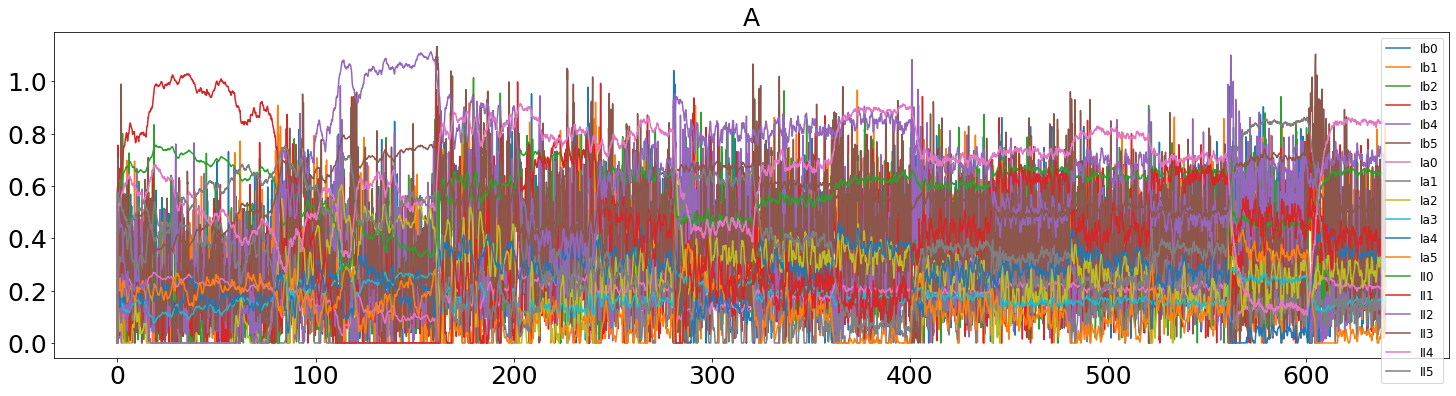

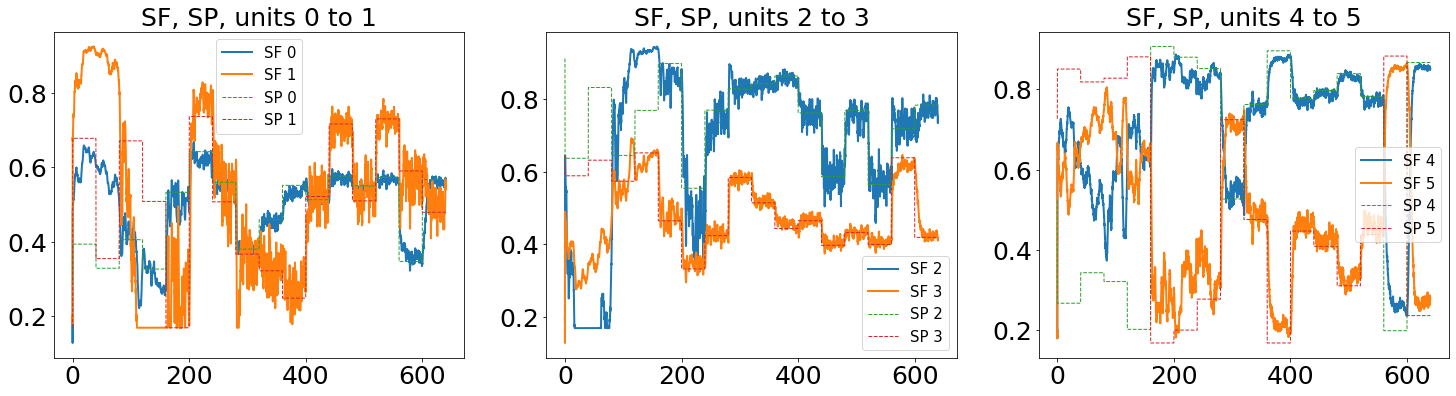

In [9]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data_l[P][:,0:4:2]
plt.plot(times_l, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',], fontsize=leg_s)
plt.title('double pendulum state variables', fontsize=tit_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

# A
A_fig = plt.figure(figsize=fs)
A_data_l = np.array(data_l[A[0:18]])
plt.plot(times_l, A_data_l.transpose())
A_legends = ['Ib' + str(i) for i in range(6)] + \
            ['Ia' + str(i) for i in range(6)] + \
            ['II' + str(i) for i in range(6)]
plt.legend(A_legends, fontsize=12)
plt.title('A', fontsize=tit_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

#fs = (30,6)
# SF, SP
SF_fig, axs = plt.subplots(1, 3, figsize=(fs[0], fs[1]))
for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=tic_s)
SF_data_l = np.array(data_l[SF])
SP_data_l = np.array(data_l[SP])
if 'lowpass_SP' in locals() and lowpass_SP is True:
    LPF_SP_data_l = np.array(data_l[LPF_SP])
for col in range(3):
    ax = axs[col]
    base = 2*col
    ax.plot(times_l, SF_data_l[base:base+2, :].transpose(), linewidth=2)
    ax.plot(times_l, SP_data_l[base:base+2, :].transpose(), '--', linewidth=1)
    if 'lowpass_SP' in locals() and lowpass_SP is True:
        ax.plot(times_l, LPF_SP_data_l[base:base+2, :].transpose(), linewidth=2)
    ax.set_title('SF, SP, units %d to %d' % (base, base+1), fontsize=tit_s)
    SF_legends = ['SF '+ str(base+i) for i in range(2)]
    SP_legends = ['SP '+ str(base+i) for i in range(2)]
    ax.legend(SF_legends + SP_legends, fontsize=leg_s)

plt.show()

average error: 0.099109


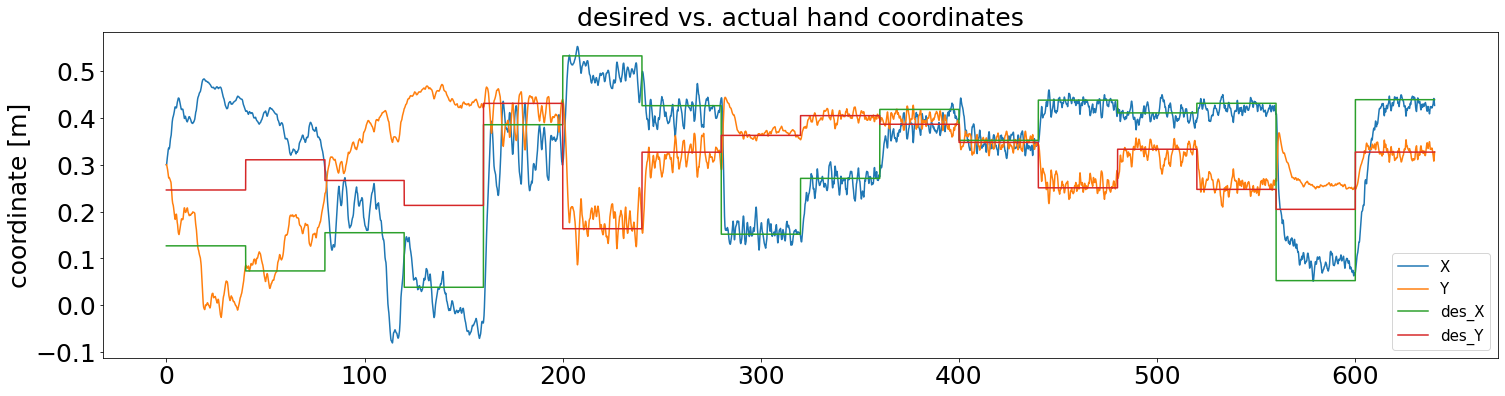

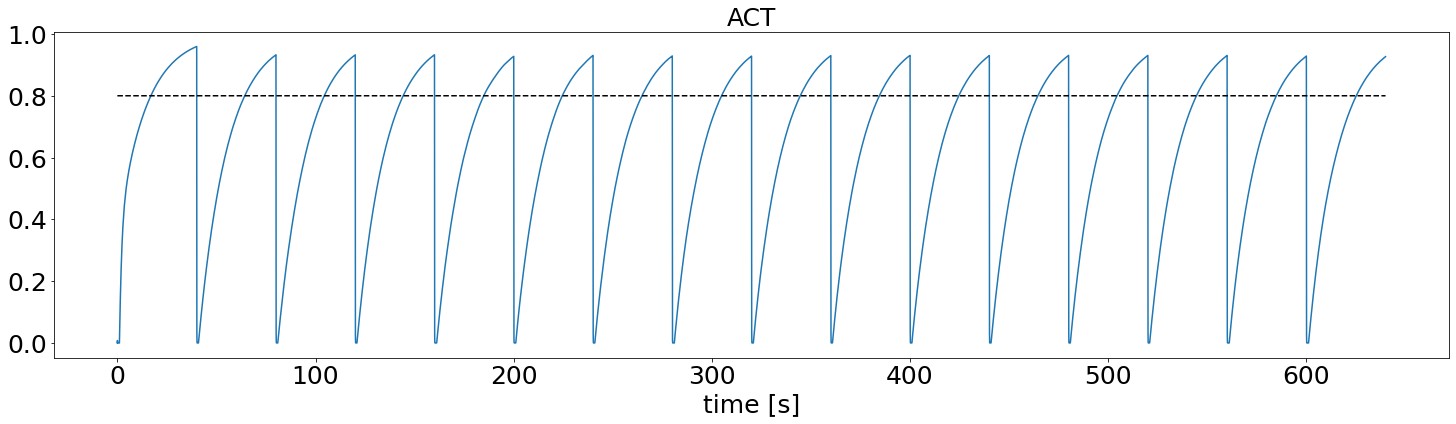

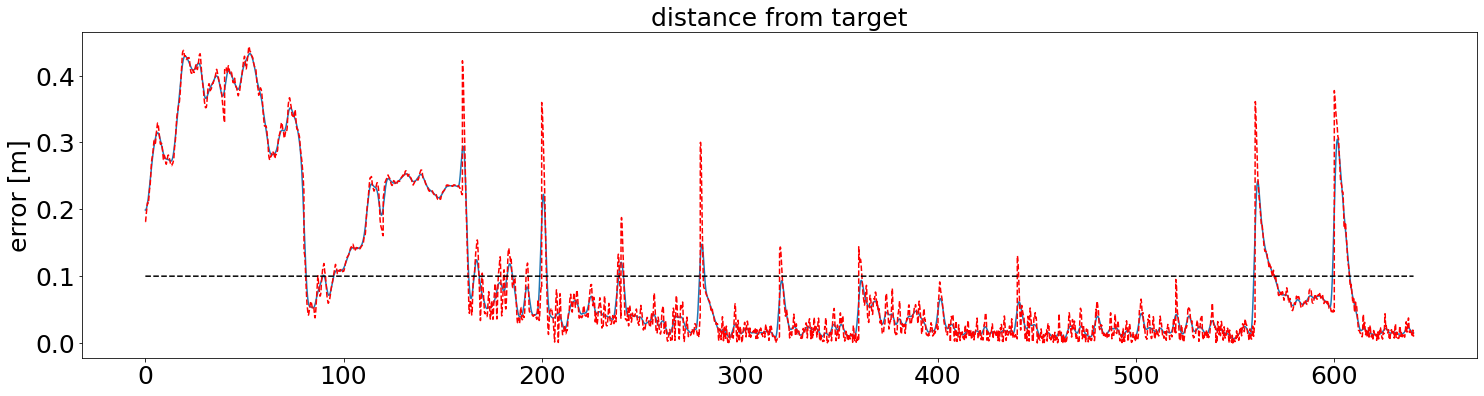

In [10]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times_l-start_t)/t_pres_l).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times_l/t_pres_l).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times_l, c_hand)
plt.plot(times_l, des_coords)
plt.title('desired vs. actual hand coordinates', fontsize=tit_s)
plt.legend(['X', 'Y', 'des_X', 'des_Y'], fontsize=leg_s)
#plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('coordinate [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

act_fig = plt.figure(figsize=fs)
act_data_l = np.array(data_l[ACT])[0]
plt.plot(times_l, act_data_l)
plt.plot(times_l, 0.8*np.ones_like(times_l), 'k--')
plt.title('ACT', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times_l, smooth_hand_error)
plt.plot(times_l, hand_error, 'r--')
plt.plot(times_l, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance from target', fontsize=tit_s)
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))
#plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('error [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

plt.show()

AL_data:
[0.11996621 0.15672445 0.08748231 0.04506582 0.04928137 0.31572501]
Ib avg for muscle 0= 0.28951223776647905
Ia avg for muscle 0= 0.10567533284750312
II avg for muscle 0= 0.2532152958124645
Ib avg for muscle 1= 0.2840446362605198
Ia avg for muscle 1= 0.08107021358781544
II avg for muscle 1= 0.193120236143444
Ib avg for muscle 2= 0.29432070977164293
Ia avg for muscle 2= 0.1397049680192365
II avg for muscle 2= 0.2796696018148268
Ib avg for muscle 3= 0.28743973321828925
Ia avg for muscle 3= 0.09744729619429224
II avg for muscle 3= 0.2394557456249574
Ib avg for muscle 4= 0.30189361990742863
Ia avg for muscle 4= 0.14648987271991962
II avg for muscle 4= 0.2863436814692104
Ib avg for muscle 5= 0.3506058908026172
Ia avg for muscle 5= 0.07200457980021968
II avg for muscle 5= 0.17807914388811946


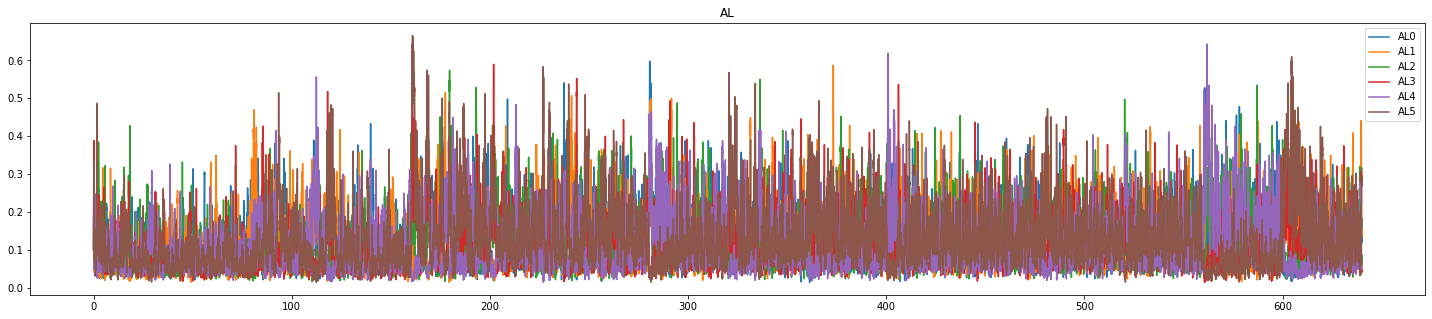

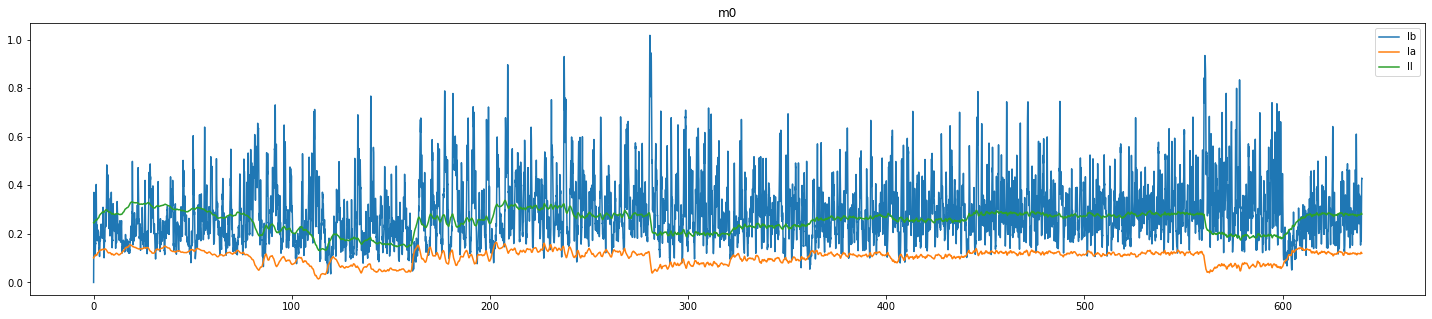

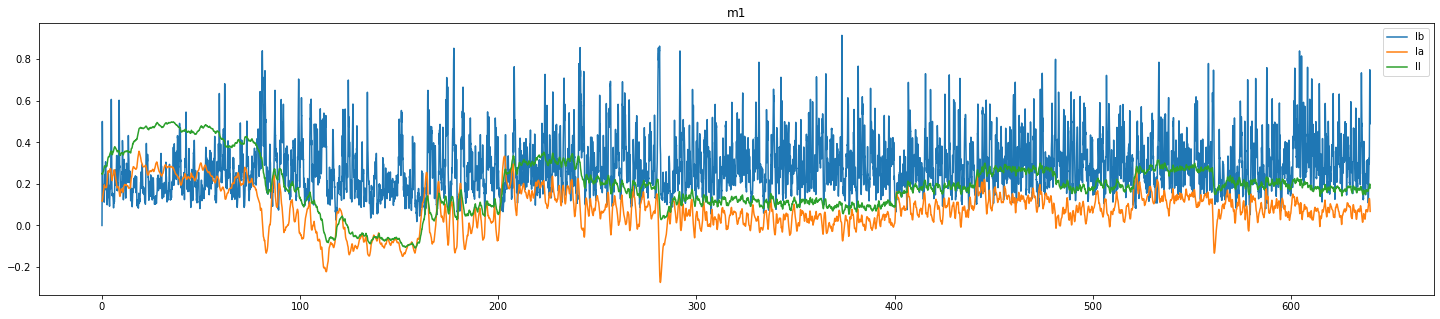

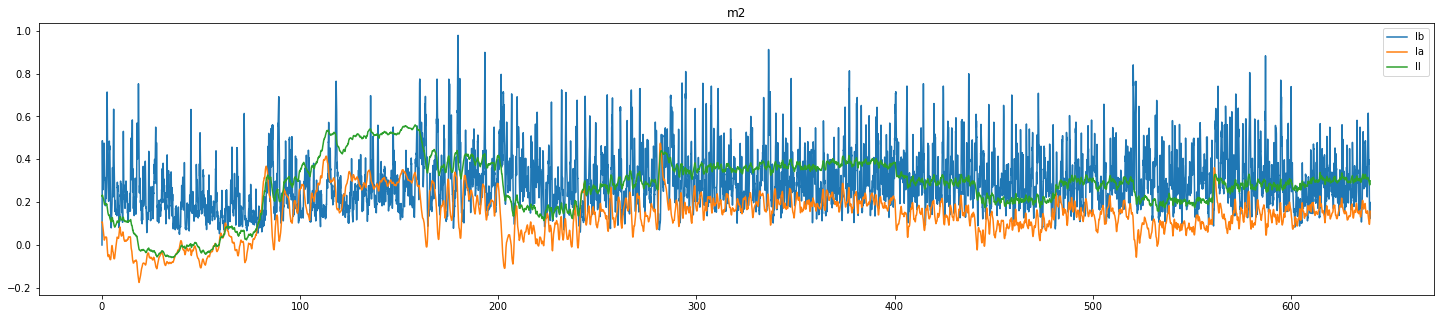

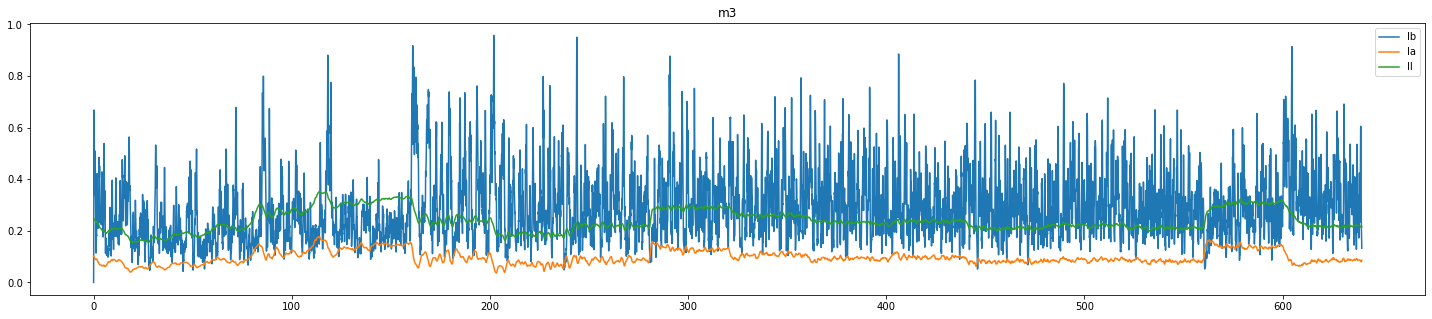

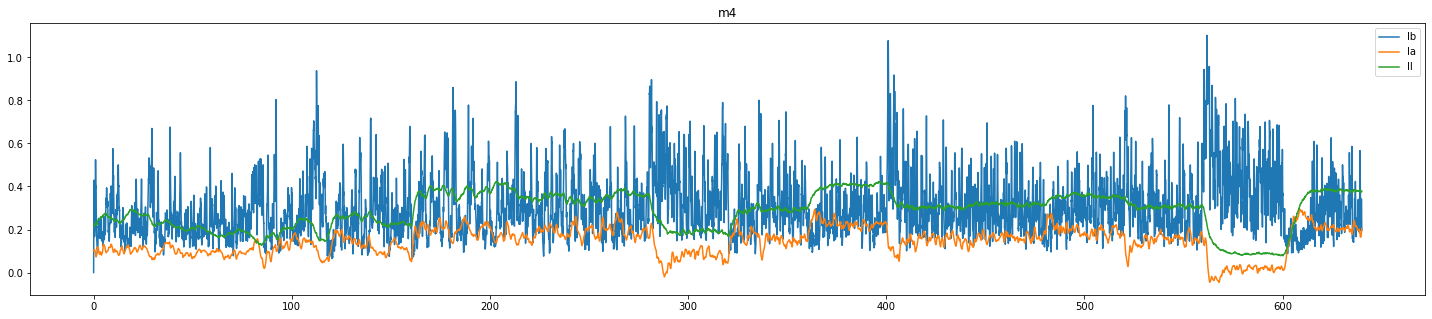

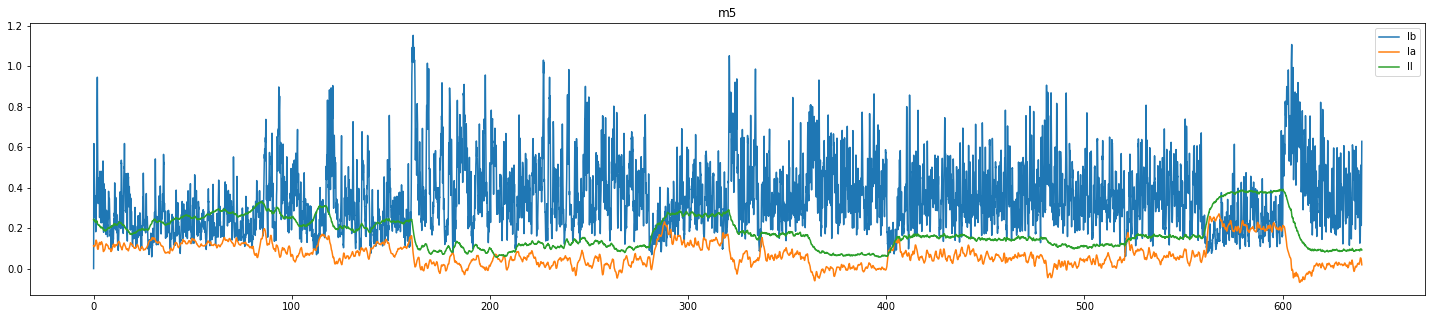

In [11]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data_l[AL])
plt.plot(times_l, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs2 =(25,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times_l, Ib, times_l, Ia, times_l, II)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

(0.0, 800.0)

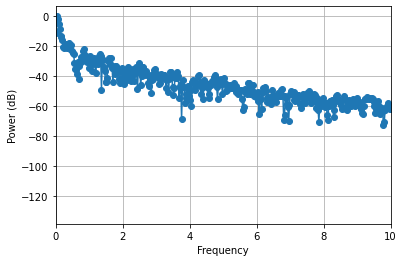

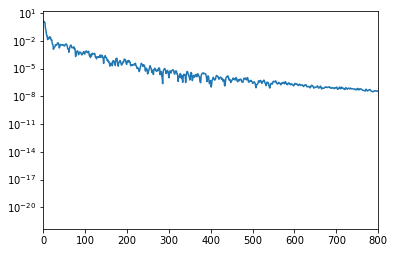

In [12]:
# power spectrum
pop_id = M[0]
init_idx = 20000
from spectrum import *
fig1 = plt.figure()
spec_data = data_l[pop_id][init_idx:init_idx+8192]
spec_data = spec_data - np.mean(spec_data)
p = Periodogram(spec_data, sampling=(1./net.min_delay))
p.plot(marker='o')
plt.xlim([0,10])

fig2 = plt.figure()
res = pmtm(spec_data, NW=2.5, k=4, show=True)
plt.xlim([0,800])

In [13]:
def set_new_targets(net,
                    pops_dict,
                    r,
                    t_pres,
                    n_trgs,
                    n_rounds,
                    pds,
                    permute_targets=True):
    """ Set new targets for reaching.
        
        Args:
            net: the draculab network
            pops_dict: dictionary with unit IDs for each population
            r: distance from center to targets
            t_pres: new presentation time
            n_trgs: number of targets
            n_rounds: number of times the n_trgs targets will be presented
            pds : parameter dictionaries used to calculate SP values.
            permute_targets: (boolean) are targets presented permuted?

            
        Returns:
            hand_coords : list with target coordinates (each a numpy 2-array).
            targets : list, only with targets
            center : only the center coordinates
            trg_ids: target used for each presentation
    """
    
    start_t = net.sim_time # starting time for new simulation
    # 8 radial targets in sequence, from 0 to 315 degrees
    r = 0.1 # distance from center to targets
    center = np.array([0.3, 0.3]) # initial hand location
    angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
    circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
    targets = center + r*circle # coordinates of the targets

    if permute_targets:
        # version with permuted targets, all are seen every 8 presentations
        trg_ids = np.random.permutation(n_trgs*n_rounds)%n_trgs # target for each presentation
        hand_coords = []
        for idx in trg_ids:
            hand_coords += [center, targets[idx]]
        hand_coords += [center] # to avoid indexes out of bounds
    else:    
        # version with sequential targets
        hand_coords = [center, targets[0],
                       center, targets[1],
                       center, targets[2],
                       center, targets[3],
                       center, targets[4],
                       center, targets[5],
                       center, targets[6],
                       center, targets[7]]
        hand_coords = n_rounds * hand_coords # many repetitions of the same sequence
        hand_coords += [center] # to avoid indexes out of bounds
        trg_ids = np.arange(len(hand_coords))%n_trgs # target for each presentation

    SP = pops_dict['SP']
    A = pops_dict['A']
    P = pops_dict['P']
    #### next is a copy-pasta of the code to set the SP values
    # list with muscle lengths corresponding to the hand coordinates
    m_lengths = []
    for coord in hand_coords:
        m_lengths.append(net.plants[P].coords_to_lengths(coord))
    m_lengths = np.array(m_lengths)
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # We need to translate these lengths to corresponding SF activity levels.
    # For that it is necessary to recreate all their transformations
    # The first transformation is from length to II afferent activity.
    ### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
    par = net.plants[P].m_params
    # steady state tensions in the static and dynamic bag fibers (no gamma inputs)
    Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
             par['k_pe_s']*(m_lengths - par['l0_s']))
    Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
             par['k_pe_d']*(m_lengths - par['l0_d']))
    # steady state afferent outputs (no gamma inputs)
    #Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
    II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
    #Ia_ss *= par['Ia_gain']
    II_ss *= par['II_gain']
    #Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
    # Next transformation is through the afferent units
    P__A_ws = np.array(pds['P__A_syn']['init_w'][12:18])
    #Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
    # target averages
    A_thr = np.array([net.units[u].thresh for u in A[12:18]])
    A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # Next is from A to SF
    SF_arg = pds['A__SF_syn']['init_w']*A_II
    SF_params = pds['SF_params']
    SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
    SF_params['init_val'] = SF_out # this might cause a smooth start
    # now we set the values in SP
    #m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    m_idxs = list(range(len(hand_coords)+1)) # reach list targets sequentially
        #m_idxs[0] = 0 # for testing
    A_us = [net.units[u] for u in A]

    def SF_sigmo(idx, arg):
        """ The sigmoidal function for SF unit with index SF[idx]. """
        return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

    def cur_target(t):
        """ Returns the index of the target at time t. """
        return m_idxs[int(np.floor((t-start_t)/t_pres))]

    def make_fun(idx):
        """ create a function for the SP unit with index 'idx'. """
        return lambda t: SF_sigmo(idx, 
                            pds['A__SF_syn']['init_w'][idx] * (
                            np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                            net.units[A[12+idx]].thresh, 0.))))

    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))
        
    return hand_coords, targets, center, trg_ids, m_idxs

In [14]:
# set new targets with the function

start_t = net.sim_time # starting time for new simulation
hand_coords, targets, center, trg_ids, m_idxs = set_new_targets(net, 
                                                          pops_dict,
                                                                  r, 
                                                             t_pres,
                                                             n_trgs, 
                                                            n_rounds,
                                                            pds)

In [15]:
# remove noise from C units
if use_syne:
    for u in [net.units[c] for c in SYNE+SYNI]:
        u.sigma = ad['new_noise']    
else:
    for u in [net.units[c] for c in CE+CI]:
        u.sigma = ad['new_noise']
    
# increase the muscle gains
for idx in range(6):
    net.plants[0].inp_syns[idx][0].w = ad['new_gain']

In [ ]:
# set new targets directly

arm = net.plants[P]
start_t = net.sim_time # starting time for new simulation
# 8 radial targets in sequence, from 0 to 315 degrees
center = np.array([0.3, 0.3]) # initial hand location
angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
targets = center + r*circle # coordinates of the targets

if permute_targets:
    # version with permuted targets, all are seen every 8 presentations
    trg_ids = np.random.permutation(n_trgs*n_rounds)%n_trgs # target for each presentation
    hand_coords = []
    for idx in trg_ids:
        hand_coords += [center, targets[idx]]
        #hand_coords += [center, center, targets[idx]]
    hand_coords += [center] # to avoid indexes out of bounds
else:    
    # version with sequential targets
    hand_coords = [center, targets[0],
                   center, targets[1],
                   center, targets[2],
                   center, targets[3],
                   center, targets[4],
                   center, targets[5],
                   center, targets[6],
                   center, targets[7]]
    hand_coords = n_rounds * hand_coords # many repetitions of the same sequence
    hand_coords += [center] # to avoid indexes out of bounds
    trg_ids = np.arange(len(hand_coords))%n_trgs # target for each presentation

#### next is a copy-pasta of the code to set the SP values
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
#m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
m_idxs = list(range(len(hand_coords)+1)) # reach list targets sequentially
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor((t-start_t)/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

In [16]:
# Run simulation for radial reaches
sim_time2 = 2 * t_pres * n_trgs * n_rounds
start_wctime = time.time()
times, data, plant_data  = net.flat_run(sim_time2)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_wctime))

Execution time is 1025.882952451706 seconds


In [17]:
start_wctime = time.time()

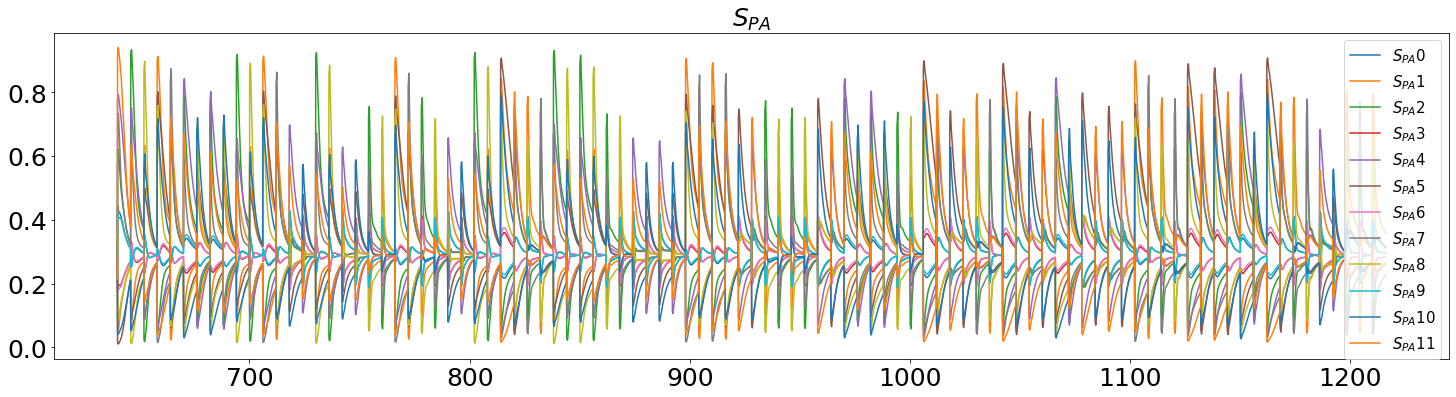

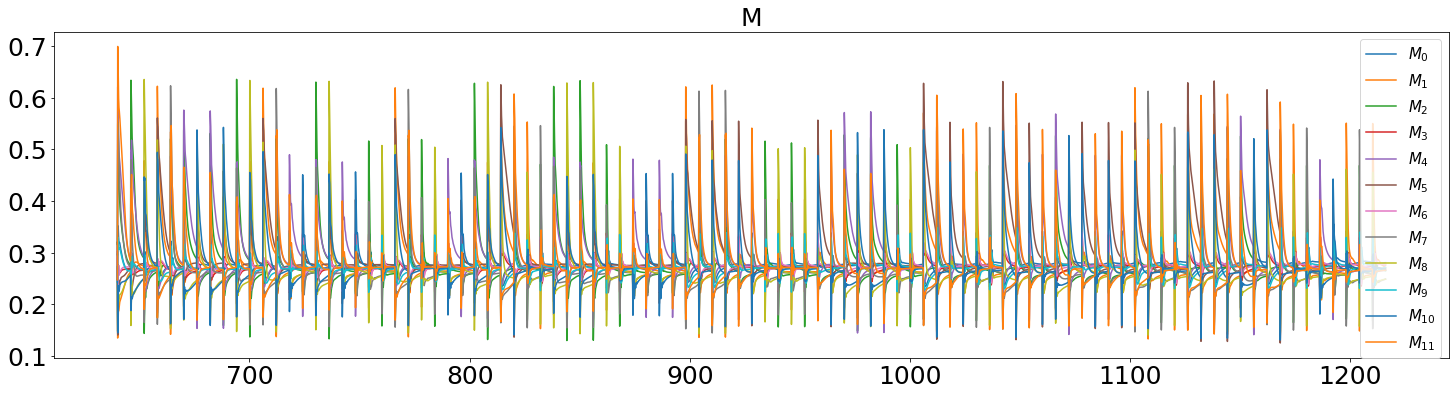

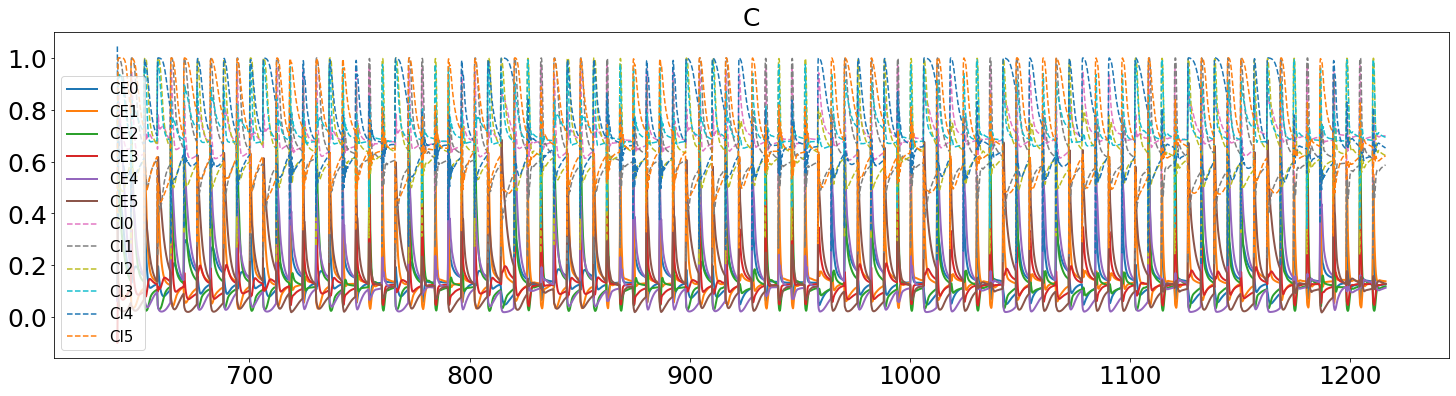

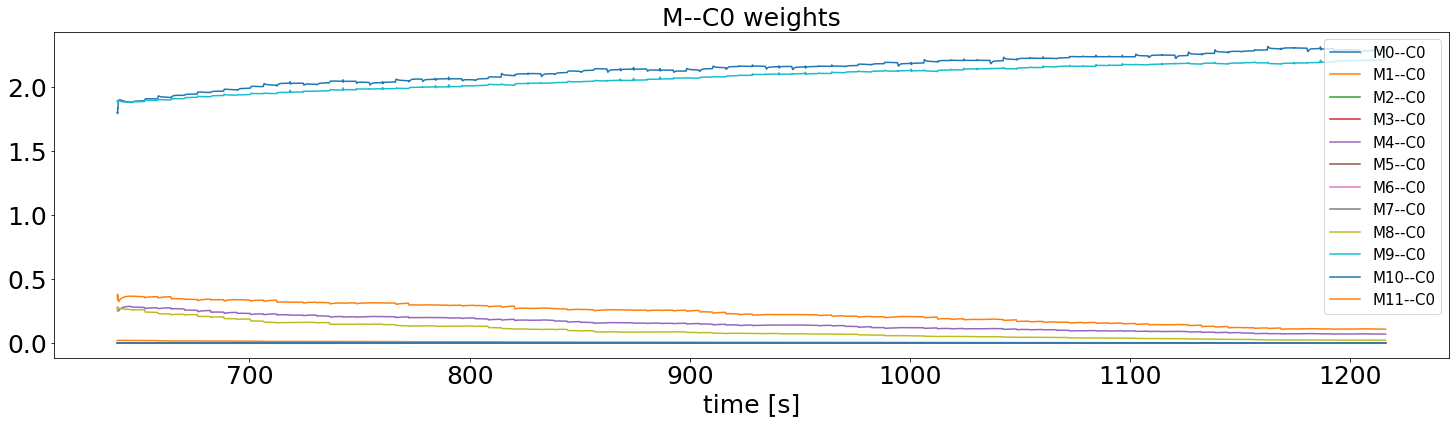

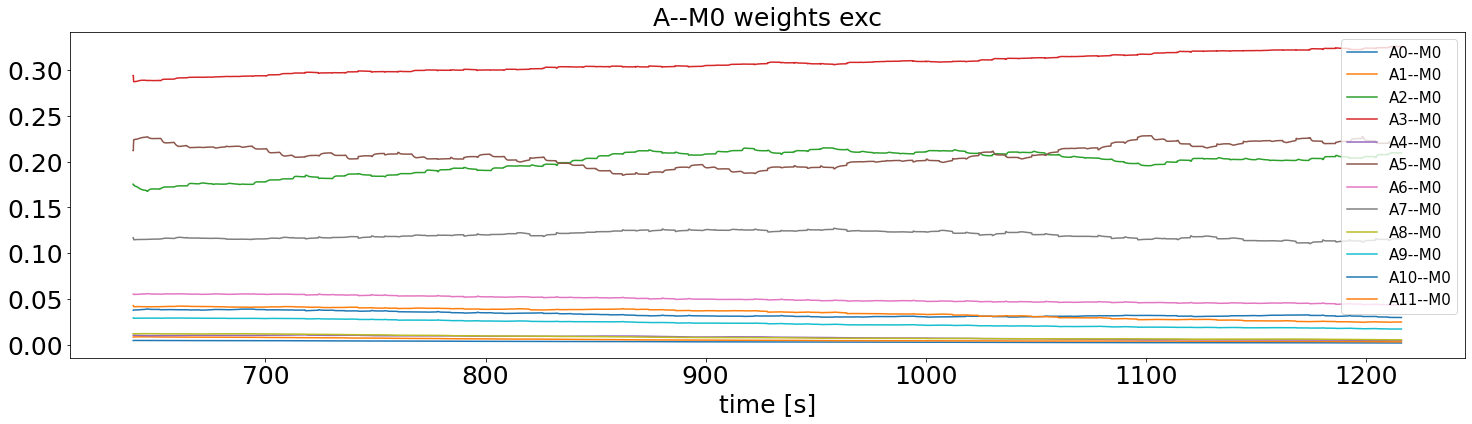

In [18]:
# Produce  the same figures

arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_ax = plt.gca()
SPF_ax.tick_params(axis='both', labelsize=tic_s)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['$S_{PA}$'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends, fontsize=15)
plt.title('$S_{PA}$', fontsize=tit_s)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['$M_{'+str(i)+'}$' for i in range(len(M))]
plt.legend(M_legends, fontsize=15)
plt.title('M', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

if use_syne:
    # SYNE, SYNI
    n_syn_f = 4 # how many unit pairs to plot
    SYN_fig = plt.figure(figsize=fs)
    SYNE_data = np.array(data[SYNE[:n_syn_f]])
    SYNI_data = np.array(data[SYNI[:n_syn_f]])
    plt.plot(times, SYNE_data.transpose(), linewidth=2)
    plt.plot(times, SYNI_data.transpose(), '--')
    SYN_legends = ['SYNE'+str(i) for i in range(n_syn_f)]
    SYN_legends += ['SYNI'+str(i) for i in range(n_syn_f)]
    plt.legend(SYN_legends, fontsize=leg_s)
    plt.title('SYN', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)
    
    # M--SYNE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data = np.array(data[M_SYNE0_track])
    plt.plot(times, w_track_data.transpose())
    M_SYNE0_legends = ['M'+str(i)+'--SYNE0' for i in range(len(M_SYNE0_track))]
    plt.legend(M_SYNE0_legends)
    plt.title('M--SYNE0 weights', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tit_s)
else:
    # C
    C_fig = plt.figure(figsize=fs)
    CE_data = np.array(data[CE])
    CI_data = np.array(data[CI])
    plt.plot(times, CE_data.transpose(), linewidth=2)
    plt.plot(times, CI_data.transpose(), '--')
    C_legends = ['CE'+str(i) for i in range(len(CE))]
    C_legends += ['CI'+str(i) for i in range(len(CI))]
    plt.legend(C_legends, fontsize=leg_s)
    plt.title('C', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

    # M--CE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data = np.array(data[M_CE0_track])
    plt.plot(times, w_track_data.transpose())
    M_CE0_legends = ['M'+str(i)+'--C0' for i in range(len(M_CE0_track))]
    plt.legend(M_CE0_legends, fontsize=15)
    plt.title('M--C0 weights', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends, fontsize=15)
plt.title('A--M0 weights exc', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[A_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
"""

plt.show()

average error: 0.035390


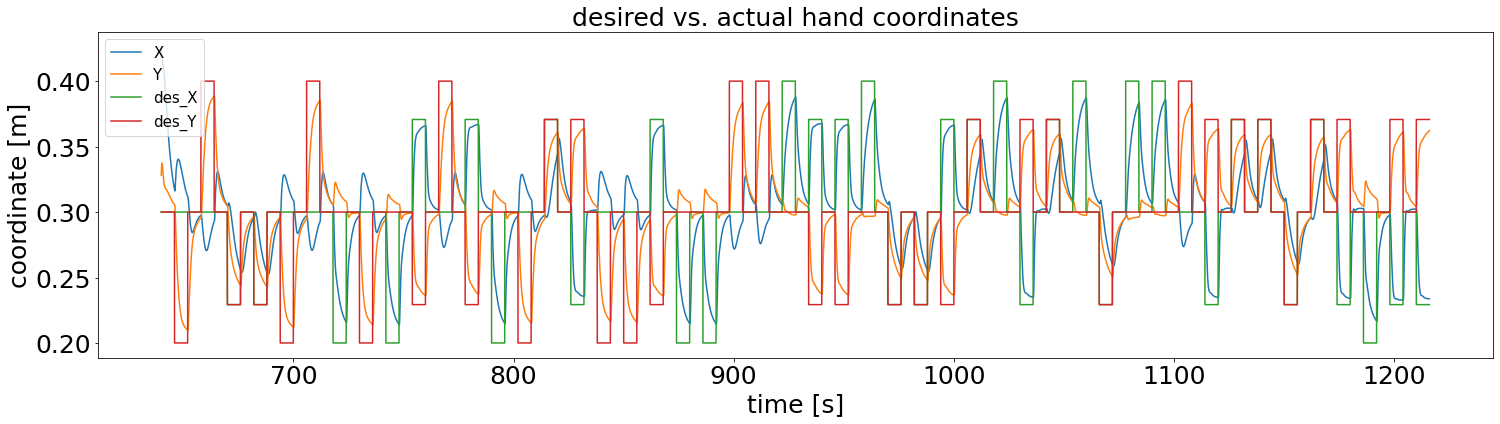

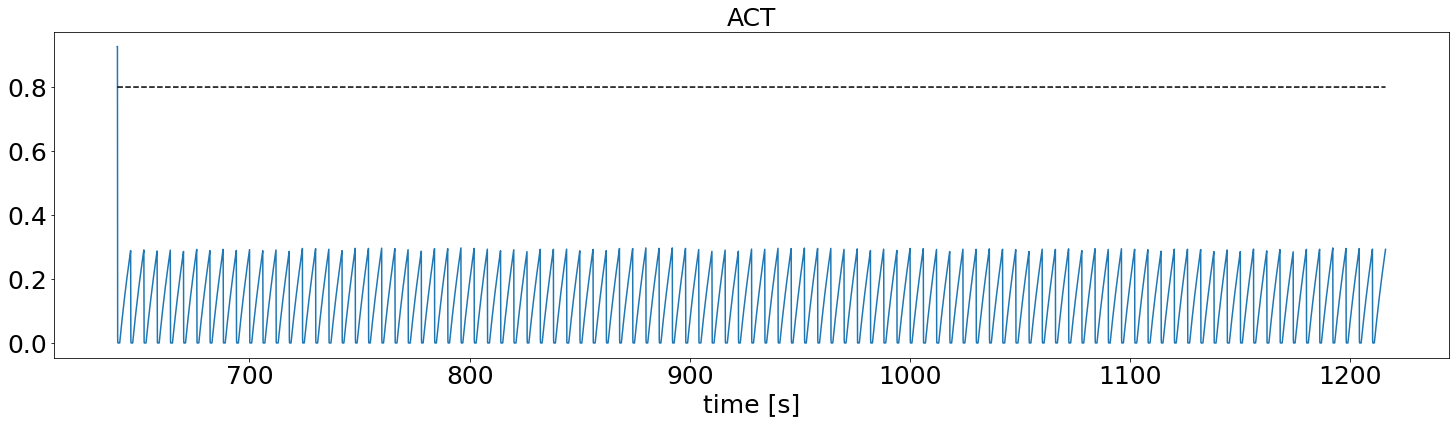

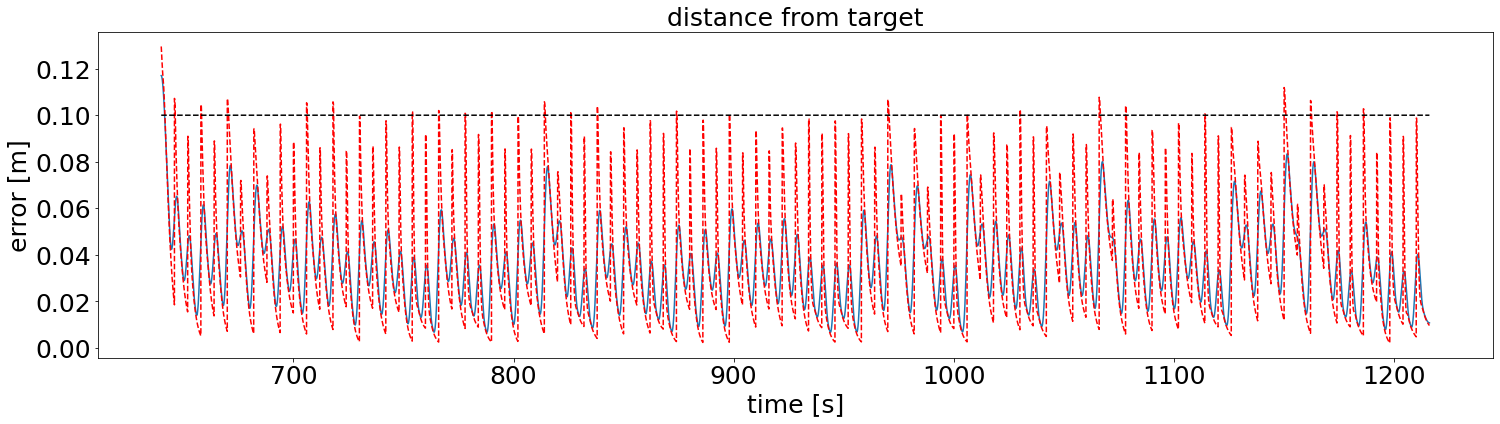

In [19]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t+1e-8)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates', fontsize=tit_s)
plt.legend(['X', 'Y', 'des_X', 'des_Y'], fontsize=leg_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('coordinate [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.plot(times, hand_error, 'r--')
plt.plot(times, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance from target', fontsize=tit_s)
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))
plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('error [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

plt.show()

In [20]:
# Functions to arrange the multiunit data from the various reaches
def get_tensor(series, J=n_trgs, K=n_rounds, T=int(round(t_pres / net.min_delay))):
    """ Given a simulation time series, arrange it by reach and repetition.
    
        Args:
            series : a time series, spanning simtime2 seconds, in min_delay steps.
            J : number of targets in the simulation.
            K : number of repetitions of each target.
            T : number of time steps that each target is presented.
            
        Returns:
            tensor : a 3-dimensional array. tensor(j,k,t) is the value of the series
                     for target j, on the k-th repetition, at time step t. Time steps
                     begin anew for each reach.
    """
    tensor = np.zeros((J, K, T))
    print(tensor.shape)
    trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled

    for reach, trg in enumerate(trg_ids):
        init_tid = (1 + 2 * reach) * T
        final_tid = init_tid + T # t_pres seconds later
        tensor[trg, trg_reps[trg],:] = series[init_tid:final_tid]
        trg_reps[trg] += 1
        
    return tensor

def get_pop_tensor(pop, J=n_trgs, K=n_rounds, t_smp =.5, t_strt=0., trg_ids=trg_ids):
    """ Returns a tensor with the activities in a population arranged by target and repetition.
    
        Args:
            pop : a list with the IDs of the populations units in the 'data' matrix.
            J : number of targets in the simulation.
            K : number of repetitions of each target.
            t_smp : time to sample per reach (in seconds)
            t_strt : time after target onset when sample begins.
            trg_ids : trg_ids[i] is the target at the i-th reach
        Returns:
            tensor : a 4-dimensional array. tensor(i,j,k,t) is the activity of the i-th
                     unit, when reaching target j, on the k-th repetition, at time step t.
    """
    idx_strt = int(t_strt / net.min_delay)
    I = len(pop)
    T=int(t_smp / net.min_delay) # number of time steps that each target is presented.
    tensor = np.zeros((I,J,K,T), dtype=np.float_)

    trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
    pt_per_pres = int(round(t_pres / net.min_delay))
    for reach, trg in enumerate(trg_ids):
        init_tid = (1 + 2 * reach) * pt_per_pres + idx_strt
        final_tid = init_tid + int(t_smp/net.min_delay) # t_smp seconds later
        tensor[:, trg, trg_reps[trg],:] = data[pop, init_tid:final_tid]
        trg_reps[trg] += 1
        
    return tensor

In [21]:
# Arrange the error data into a tensor
# he_tensor[j,k,t] is the hand tensor for target j,
# o the k-th presentation, at time t
J = n_trgs # number of targets
K = n_rounds # number of repetitions per target
T = int(round(t_pres / net.min_delay)) # number of time points

he_tensor = get_tensor(hand_error, J=J, K=K, T=T)
# he_tensor = np.zeros((J, K, T))
# trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
# #pt_per_pres = int(round(t_pres / net.min_delay))
# for reach, trg in enumerate(trg_ids):
#     init_tid = (1 + 2 * reach) * T
#     final_tid = init_tid + T # t_pres seconds later
#     he_tensor[trg, trg_reps[trg],:] = hand_error[init_tid:final_tid]
#     trg_reps[trg] += 1
    
# we average across repetitions of the same target
ahe_trg = he_tensor.sum(axis=1) / K

# we average across all reaches
ahe = ahe_trg.sum(axis=0) / J

(8, 6, 1200)


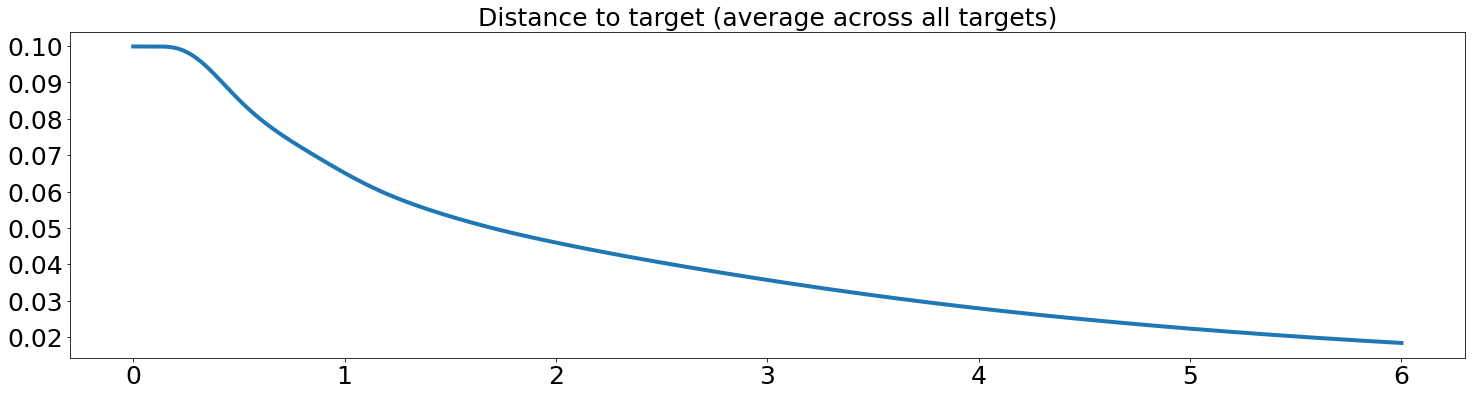

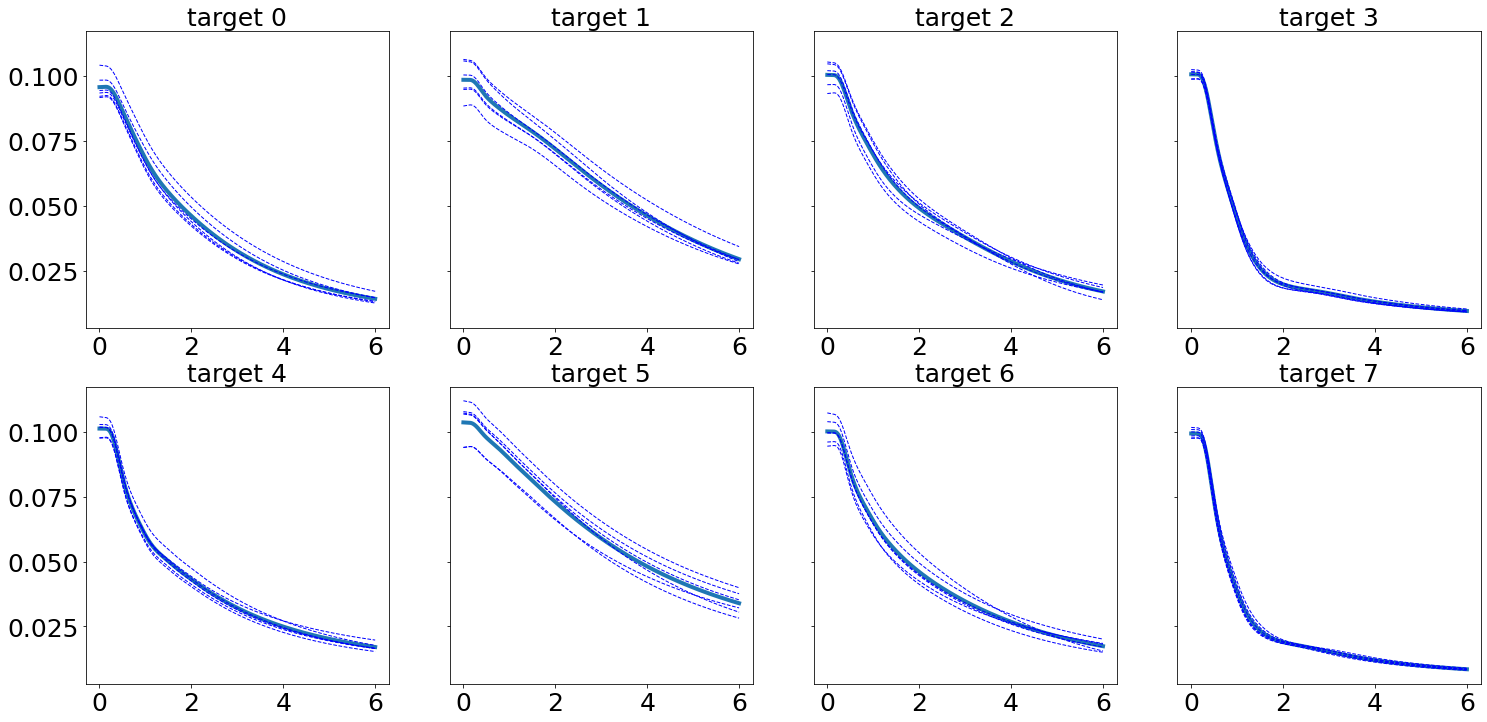

In [22]:
# Print distance to target for each target
ahe_fig = plt.figure(figsize=fs)
reach_ts = np.linspace(0., t_pres, T)
plt.plot(reach_ts, ahe, linewidth=4)
plt.title("Distance to target (average across all targets)", fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

n_rows = 2
n_cols = 4
ahe_trg_fig, ahe_trg_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], 2*fs[1]), sharey=True)
for row in range(n_rows):
    for col in range(n_cols):
        ax = ahe_trg_axs[row,col]
        trg = row*n_cols + col
        ax.plot(reach_ts, ahe_trg[trg, :], linewidth=4)
        ax.tick_params(axis='both', labelsize=tic_s)
        ax.set_title("target " + str(trg), fontsize=tit_s)
        for rep in range(K):
            ax.plot(reach_ts, he_tensor[trg,rep,:], '--', linewidth=1, color='b')

plt.show()

In [23]:
# Obtain hand coordinates through time
from numpy import cos, sin
if not 'targets' in locals():
    targets = np.array([[0.3, 0.3]])

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
ipx = data[ipx_track,:]
ipy = data[ipy_track,:]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2

# placing hand coordinates in tensors (arrange by target, repetition)
xh_tensor = get_tensor(xh, J=J, K=K, T=T)
yh_tensor = get_tensor(yh, J=J, K=K, T=T)

# xh_tensor = np.zeros((J, K, T))
# yh_tensor = np.zeros((J, K, T))
# trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
# for reach, trg in enumerate(trg_ids):
#     init_tid = (1 + 2 * reach) * T
#     final_tid = init_tid + T
#     xh_tensor[trg, trg_reps[trg], :] = xh[init_tid:final_tid]
#     yh_tensor[trg, trg_reps[trg], :] = yh[init_tid:final_tid]
#     trg_reps[trg] += 1
    
# average across reptitions of the same target
axh_trg = xh_tensor.sum(axis=1) / K
ayh_trg = yh_tensor.sum(axis=1) / K

(8, 6, 1200)
(8, 6, 1200)


In [24]:
# Obtain velocity profile for the reaches
xph = np.concatenate(([0], (xh[1:] - xh[:-1]) / net.min_delay))
yph = np.concatenate(([0], (yh[1:] - yh[:-1]) / net.min_delay))
hv = np.sqrt(xph*xph + yph*yph)

# def get_tensor(series, J=n_trgs, K=n_rounds, T=int(round(t_pres / net.min_delay))):
#     """ Given a simulation time series, arrange it by reach and repetition.
    
#         Args:
#             series : a time series, spanning simtime2 seconds, in min_delay steps.
#             J : number of targets in the simulation.
#             K : number of repetitions of each target.
#             T : number of time steps that each target is presented.
            
#         Returns:
#             tensor : a 3-dimensional array. tensor(j,k,t) is the value of the series
#                      for target j, on the k-th repetition, at time step t. Time steps
#                      begin anew for each reach.
#     """
#     tensor = np.zeros((J, K, T))
#     trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled

#     for reach, trg in enumerate(trg_ids):
#         init_tid = (1 + 2 * reach) * T
#         final_tid = init_tid + T # t_pres seconds later
#         tensor[trg, trg_reps[trg],:] = series[init_tid:final_tid]
#         trg_reps[trg] += 1
        
#     return tensor

# xph_tensor = get_tensor(xph)
# yph_tensor = get_tensor(yph)
hv_tensor = get_tensor(hv)

# we average across repetitions of the same target
ahv_trg = hv_tensor.sum(axis=1) / K

# we average across all reaches
ahv = ahv_trg.sum(axis=0) / J

(8, 6, 1200)


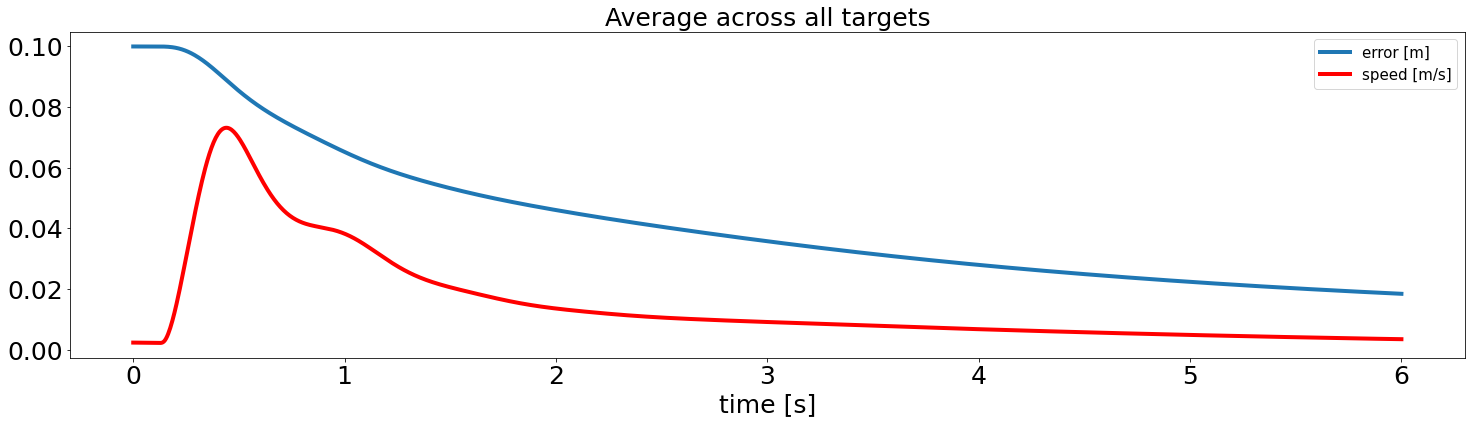

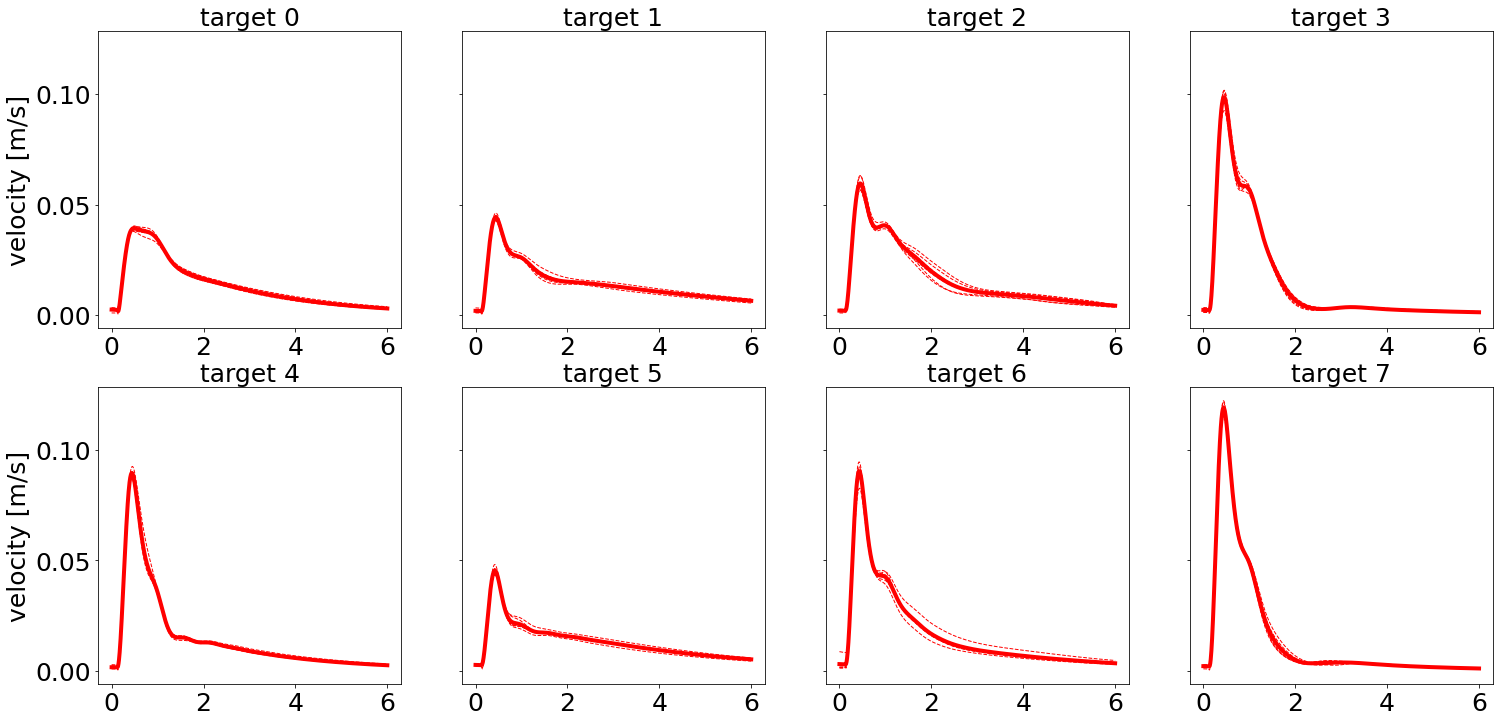

In [25]:
# Print velocity for each target
ahv_fig = plt.figure(figsize=fs)
reach_ts = np.linspace(0., t_pres, T)
plt.plot(reach_ts, ahe, linewidth=4)
plt.plot(reach_ts, ahv,  'r', linewidth=4)
#plt.title("hand velocity (average across all targets)", fontsize=tit_s)
plt.title("Average across all targets", fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
#plt.ylabel('velocity [m/s]', fontsize=lab_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.legend(['error [m]', 'speed [m/s]'], fontsize=leg_s)

n_rows = 2
n_cols = 4
ahv_trg_fig, ahv_trg_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], 2*fs[1]), sharey=True)
for row in range(n_rows):
    for col in range(n_cols):
        ax = ahv_trg_axs[row,col]
        trg = row*n_cols + col
        ax.plot(reach_ts, ahv_trg[trg, :], 'r', linewidth=4)
        ax.tick_params(axis='both', labelsize=tic_s)
        ax.set_title("target " + str(trg), fontsize=tit_s)
        for rep in range(K):
            ax.plot(reach_ts, hv_tensor[trg,rep,:], '--', linewidth=1, color='red')
        if col==0:
            ax.set_ylabel('velocity [m/s]', fontsize=lab_s)

plt.show()

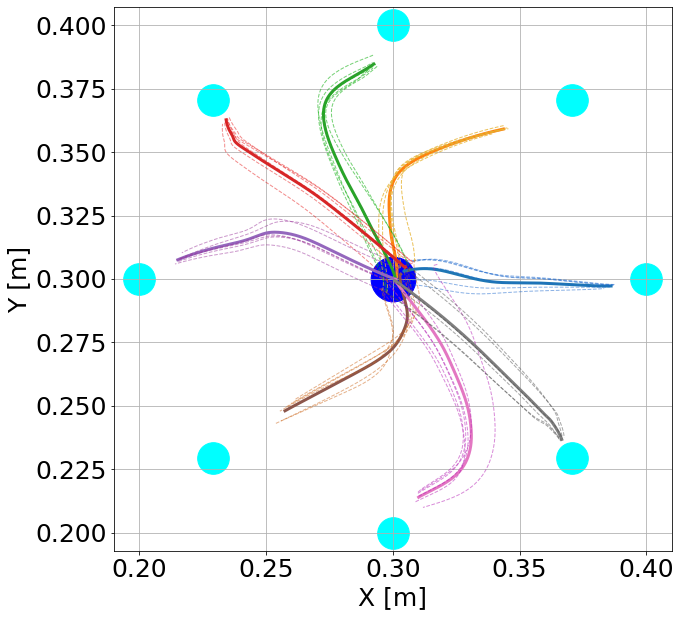

In [26]:
# plot average reach trajectories and some individual reaches
n_ind_reaches = 6 # number of example reaches to plot
reach_fig = plt.figure(figsize=(10,10))
reach_ax = plt.gca()
trial = 0
reach_ax.scatter(targets[:,0], targets[:,1], s=1000, c='cyan')
#reach_ax.scatter(center[0]+.7*(targets[:,0]-center[0]), 
#                 center[1]+.7*(targets[:,1]-center[1]), s=1000, c='k', alpha=0.3)
#reach_ax.scatter(.6*(targets[:,0]+center[0]), .6*(targets[:,1]+center[1]), s=1000, c='cyan', alpha=0.4)
reach_ax.scatter(center[0], center[1], s=2000, c='blue')
reach_ax.tick_params(axis='both', labelsize=tic_s)
reach_ax.set_xlabel('X [m]', fontsize=lab_s)
reach_ax.set_ylabel('Y [m]', fontsize=lab_s)
reach_ax.set_xticks([0.2, 0.25, 0.3, 0.35, 0.4])
reach_ax.set_xticks([0.2, 0.25, 0.3, 0.35, 0.4])
plt.axis('equal')
reach_ax.grid()
cmap = [[0.1, 0.4, 0.8, 0.5],
        [0.9, 0.7, 0.2, 0.8],
        [0.1, 0.7, 0.1, 0.6],
        [0.9, 0.1, 0.1, 0.5],
        [0.6, 0.2, 0.6, 0.5],
        [0.8, 0.4, 0.1, 0.5],
        [0.7, 0.1, 0.7, 0.5],
        [0.3, 0.3, 0.3, 0.5]]
for trg in range(J):
    reach_ax.plot(axh_trg[trg,:], ayh_trg[trg,:], linewidth=3)
    for rep in range(min(n_ind_reaches, K)):
        reach_ax.plot(xh_tensor[trg, rep, :], yh_tensor[trg, rep, :], '--', linewidth=1, color=cmap[trg])
#from IPython.display import Image
#Image(filename='temp_fig')
#plt.savefig('temp_fig2')
plt.show()

(0.0, 800.0)

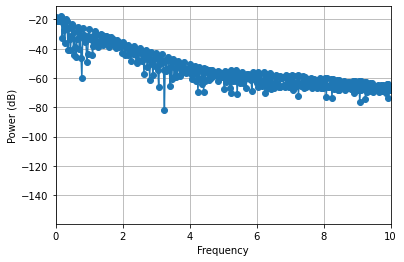

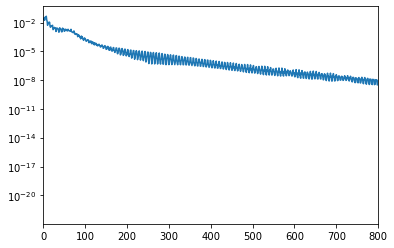

In [27]:
# power spectrum
pop_id = M[0]
from spectrum import *
fig1 = plt.figure()
spec_data = data[pop_id][0:8192]
spec_data = spec_data - np.mean(spec_data)
p = Periodogram(spec_data, sampling=(1./net.min_delay))
p.plot(marker='o')
plt.xlim([0,10])

fig2 = plt.figure()
res = pmtm(spec_data, NW=2.5, k=4, show=True)
plt.xlim([0,800])

---
### Direction tuning analysis
---

In [28]:
# Obtaining the prefered directions for the units in M
# Find the mean rate for each target
t_smp = 1. # time to sample M (in seconds)
I = 12 # number of units to consider in M
m_tensor = get_pop_tensor(M[:I], t_smp=t_smp)
# m_tensor[i,j,k,t] is the activity of the i-th M 
# unit for target j, on the k-th repetition, at time point t.

# Now we average across repetitions for the same target
m_tensor_trg_avg = m_tensor.sum(axis=2) / K
# m_tensor_trg_avg[i,j,t]: average activity of i-th M unit when
# reaching for target j, at time point t

m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
for trg in range(J):
    m_avg_rates[:, trg] = np.mean(m_tensor_trg_avg[:, trg, :], axis=1)

m_means = np.mean(m_avg_rates, axis=1) # mean rate for each unit
    
# Obtaining preferred directions by fitting the rates using a plane, and using
# the angle of the projection of this plane's normal vector onto the XY plane
# The coefficients of the normal vector can be calculated using the least-squares
# method, which leads to a 3x3 linear system that is readily reduced to a 2x2 system.
trgs = targets - center # targets centered at the origin
xs = trgs[:,0]
ys = trgs[:,1]
cxs = xs - np.mean(xs) # "centered" x coordinates
cys = ys - np.mean(ys) #  "centered" Y coordinates

X11 = (xs * cxs).sum()
X12 = (xs * cys).sum()
X21 = (ys * cxs).sum()
X22 = (ys * cys).sum()

Amat = np.array([[X11, X12], [X21, X22]])
detA = np.linalg.det(Amat) # determinant of Amat
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Amat)

prf_angs = np.zeros(len(M)) # preferred angles, in radians
normal_vecs = [] # list with the vectors normal to the plane fitting the rates

for uid in range(I):
    r1 = (xs * (m_avg_rates[uid, :] - m_means[uid])).sum()
    r2 = (ys * (m_avg_rates[uid, :] - m_means[uid])).sum()
    n = np.matmul(invA, np.array([r1,r2]))
    # boils down to
    #n = [a,b] where b = r2/X22, a = r1/X11
    #normal_vecs.append(n / np.linalg.norm(n)) # appending normalized vector
    normal_vecs.append(n)
    prf_angs[uid] = np.arctan2(n[1], n[0]) # preferred angle
    #print("n1=%f, n0=%f, prf_ang=%f"%(n[1],n[0]))

    c = np.mean(m_avg_rates[uid,:] - n[0]*xs - n[1]*ys)
    
    # obtaining residuals, coefficient of determination, R^2
    residuals = m_avg_rates[uid,:] - n[0]*xs - n[1]*ys - c
    devs = m_avg_rates[uid,:] - m_means[uid]
    SSr = (residuals * residuals).sum()
    SSt = (devs * devs).sum()
    R = 1. - (SSr/SSt)
    print(R)

normal_vecs = np.array(normal_vecs)

# Get the lengths of the preferred direction vectors
pd_norms = np.linalg.norm(normal_vecs, axis=1)

0.6338855242638797
0.8595913098588708
0.8395341061034651
0.7480650762676644
0.8769460789973774
0.8707040995935785
0.6667800798141259
0.9606085341244828
0.9675736266459549
0.7843548993027656
0.9414271115123192
0.9618119361444993


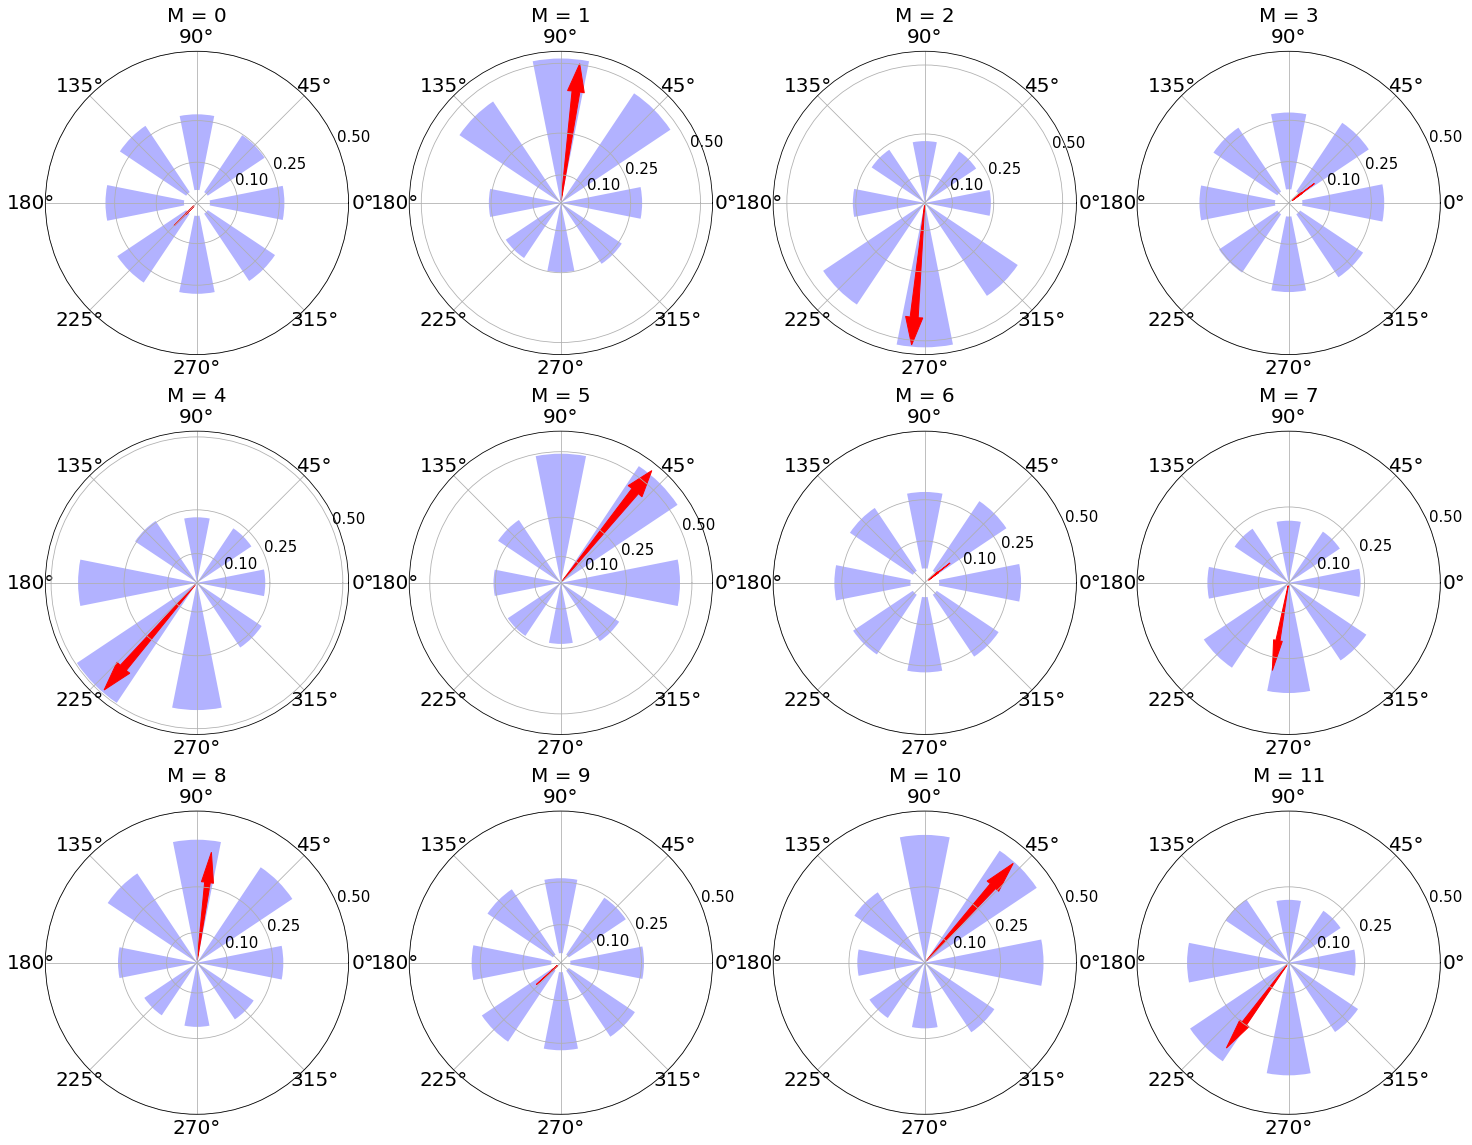

In [29]:
# Plot direction tuning for all M units

dir_fig, dir_axs = plt.subplots(3, 4, figsize=(fs[0], 3.3*fs[1]), subplot_kw=dict(projection='polar'))

# m_avg_rates[i,j]: average rate of i-th M unit 
# when reaching for target j
span = max(m_avg_rates.flatten()) * max(trgs.flatten())
theta = np.linspace(0.0, 2 * np.pi, J, endpoint=False)
width = np.pi / J
for row in range(3):
    for col in range(4):
        ax = dir_axs[row][col]
        m_id = 4*row + col
        ax.set_title("M = %d" % (m_id), fontsize=20) 
        ax.bar(theta, m_avg_rates[m_id, :], width=width, bottom=0.0, color='b', alpha=0.3)
        #ax.bar(prf_angs[m_id], .5*pd_norms[m_id], width=np.pi/32, bottom=0.0, color='r')
        ax.arrow(prf_angs[m_id],.01, 0., .35*pd_norms[m_id], width=0.07,
             head_width=0.15, head_length=0.1, length_includes_head=True, color='r')
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=15)
        if use_syne:
            ax.set_yticks([.2, .4, .6])
        else:
            ax.set_yticks([.1, .25, .5])
                    
plt.show()

To assess how many units are "significantly tuned" to reach direction we can use a bootstrap method. Basically, you shuffle the identities of the targets used (the `trg_ids` array), and calculate the length of the preferred direction (PD) vector (`normal_vecs`) for each cell. After producing $N$ different permutations of the targets, you have $N$ PD vectors for each unit. A cell is significantly tuned if the length of its PD vector is larger than $.999N$ of the PD vectors.

This is based on [Scott and Kalaska 1997](https://journals.physiology.org/doi/full/10.1152/jn.1997.77.2.826).

In [30]:
# Assess if significantly tuned to direction

N_shuffles = 10000 # number of target permutations to produce
sh_pd_norms = np.zeros((I, N_shuffles)) # magnitude of PD vector for each cell, all shuffles
#m_rates_tensor = np.mean(m_tensor, axis=3)
# m_rates_tensor[i,j,k]: mean firing rate for cell i on k-th presentation of target j
for n_idx in range(N_shuffles):
    sh_trg_ids = np.random.permutation(trg_ids)
    sh_m_tensor = get_pop_tensor(M[:I], J=J, K=K, t_smp=t_smp, trg_ids=sh_trg_ids)
    sh_m_tensor_trg_avg = sh_m_tensor.sum(axis=2) / K
    sh_m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
    for trg in range(J):
        sh_m_avg_rates[:, trg] = np.mean(sh_m_tensor_trg_avg[:, trg, :], axis=1)
    sh_m_means = np.mean(sh_m_avg_rates, axis=1) # mean rate for each unit
    sh_normal_vecs = np.zeros((I,2))
    for uid in range(I):
        r1 = (xs * (sh_m_avg_rates[uid, :] - sh_m_means[uid])).sum()
        r2 = (ys * (sh_m_avg_rates[uid, :] - sh_m_means[uid])).sum()
        n = np.matmul(invA, np.array([r1,r2]))
        sh_normal_vecs[uid,:] = n
    sh_pd_norms[:, n_idx] = np.linalg.norm(sh_normal_vecs, axis=1)
    
# Now, for each unit, find vlue of sh_pd_norms that is larger than 99%
sig_threshs = np.percentile(sh_pd_norms, 99.9, axis=1)

# For each unit, check if it is significantly tuned
tuned = pd_norms >= sig_threshs
print(tuned)
n_tuned = tuned.sum()
print(n_tuned)

[ True  True  True  True  True  True  True  True  True  True  True  True]
12


In [31]:
# Decode which target was reached based on the M firing rate
# We get the sum of prefered directions, each modulated by the
# average firing rate. The desired target will be the one closest to
# the decoded direction.
# We can do this for all individual reaches

pred_dirs = np.empty((J,K), dtype=np.int_)
#pred_dirs(j,k): predicted direction on reach j, repetition k
for target in range(J):
    for reach in range(K):
        # we obtain the average firing rate for all cells at that reach
        m_reach_avg = np.mean(m_tensor[:, target, reach, :], axis=1).reshape(12,1)
        pd = (m_reach_avg * normal_vecs).sum(axis=0).reshape(2,1) # predicted direction
        # We select the target with the largest inner product with pd
        # trgs (obtained before) has the targets centered at the origin
        dot_prods = np.matmul(trgs, pd)
        pred_dir = np.argmax(dot_prods)
        pred_dirs[target, reach] = pred_dir
        
print(pred_dirs)

pdrows, pdcols = pred_dirs.shape
pred_frac = (np.tile(np.arange(pdrows).reshape(pdrows,1), pdcols) == 
             pred_dirs).sum() / pred_dirs.size
print(pred_frac)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [5 5 5 5 5 5]
 [5 5 5 5 5 5]
 [6 6 6 6 6 6]
 [6 6 7 6 6 7]]
0.4166666666666667


In [32]:
# normalized pd version
# Decode which target was reached based on the  M firing rate
# We get the sum of prefered directions, each modulated by the
# average firing rate. The desired target will be the one closest to
# the decoded direction.
# We can do this for all individual reaches

normal_normal_vecs = [vec / np.linalg.norm(vec) for vec in normal_vecs]
pred_dirs = np.empty((J,K), dtype=np.int_)
#pred_dirs(j,k): predicted direction on reach j, repetition k
for target in range(J):
    for reach in range(K):
        # we obtain the average firing rate for all cells at that reach
        m_reach_avg = np.mean(m_tensor[:, target, reach, :], axis=1).reshape(12,1)
        pd = (m_reach_avg * normal_normal_vecs).sum(axis=0).reshape(2,1) # predicted direction
        # We select the target with the largest inner product with pd
        # trgs (obtained before) has the targets centered at the origin
        dot_prods = np.matmul(trgs, pd)
        pred_dir = np.argmax(dot_prods)
        pred_dirs[target, reach] = pred_dir

print(pred_dirs)

pdrows, pdcols = pred_dirs.shape
pred_frac = (np.tile(np.arange(pdrows).reshape(pdrows,1), pdcols) == 
             pred_dirs).sum() / pred_dirs.size
print(pred_frac)

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [5 5 5 5 5 5]
 [5 5 5 5 5 5]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]]
0.375


Under the assumption that the angles $\phi_i$ are uniformly distributed on $[0, 2\pi)$, and for large enough $N$, the sums $\frac{2}{N} \sum_{i=1}^N \sin(\phi_i)$, and $\frac{2}{N} \sum_{i=1}^N \cos(\phi_i)$ will approximately have a Gaussian distribution with zero mean and variance one.

The statistic $ r = \frac{2}{N} \left( \big( \sum_{i=1}^N \sin(\phi_i) \big)^2 + \big( \sum_{i=1}^N \cos(\phi_i) \big)^2 \right)$ will have a chi-square distribution with 2 degres of freedom, which has a PDF
$f(x) = x \exp(x^2/2), x \geq 0$, and a CDF $F(x) = 1 - \text{e}^\frac{-x^2}{2}$.

If you want to know a value $x_c$ such that $P(x \leq x_c) = a$, the CDF tells you that
$x_c = \sqrt{-2 \ln (1 -a)}$.

From the supplementary material to Lillicrap and Scott 2013, for the bimodal case, the angle $\theta$ for the dominant axis of the skew comes from the formula:
$\theta = \mod \left( \frac{1}{2} \arctan \left( \frac{\sum_{i=1}^N \sin(\phi_i)}{\sum_{i=1}^N \cos(\phi_i)} \right) \right)$, where mod() is meant to give you an angle between 0 and $\pi$.

See:
* [Suppementary material](https://ars.els-cdn.com/content/image/1-s2.0-S0896627312009920-mmc1.pdf) to [Lillicrap and Scott 2013](https://www.sciencedirect.com/science/article/pii/S0896627312009920).
* https://en.wikipedia.org/wiki/Rayleigh_distribution
* https://www.astro.ubc.ca/people/jvw/ASTROSTATS/Answers/Chap9/chapter%209%20rayleigh%20test.pdf


Angle of dominant axis: -24.015067


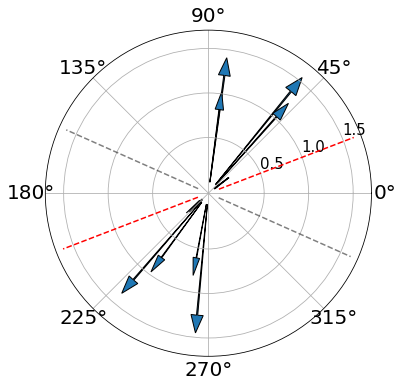

In [33]:
# plot of preferred directions for the 12 cells

# Find the angle of the dominant axis of the skew (bimodal version)
dom_ang = 0.5*np.arctan2(np.sin(prf_angs).sum(), np.cos(prf_angs).sum())
dom_ang_deg = dom_ang * 180./np.pi # angle of dominant axis in degrees
print("Angle of dominant axis: %f" %(dom_ang_deg))

#sig_prf_angs = prf_angs
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=fs)
#ax.plot(prf_angs, np.ones(len(prf_angs)), '*')
#ax.plot(prf_angs, pd_norms, '^')
for uid in range(len(prf_angs)):
    ax.arrow(prf_angs[uid],.001, 0., pd_norms[uid], width=0.01,
             head_width=0.1, head_length=0.2, length_includes_head=True)
#ax.bar(prf_angs, np.ones(len(prf_angs)), width=np.pi/40, color='b', alpha=0.3)
#ax.bar(prf_angs, pd_norms, width=np.pi/40, alpha=0.3)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_yticks([.5, 1., 1.5])
ax.set_rmax(1.1*max(pd_norms))
ax.plot([dom_ang, dom_ang], [0., 1.05*max(pd_norms)], 'k--', alpha=0.5)
ax.plot([dom_ang+np.pi, dom_ang+np.pi], [0., 1.05*max(pd_norms)], 'k--', alpha=0.5)
ax.plot([dom_ang+np.pi/4., dom_ang+np.pi/4.], [0., 1.05*max(pd_norms)], 'r--')
ax.plot([dom_ang+np.pi+np.pi/4., dom_ang+np.pi+np.pi/4.], [0., 1.05*max(pd_norms)], 'r--')
plt.show()


Angle of dominant axis: -24.015067


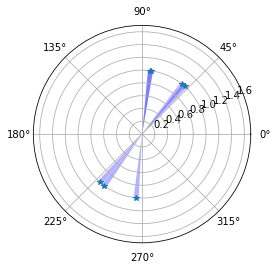

In [34]:
# plot of preferred directions for the 12 cells, only ones with large norm
big_norms_idx = np.arange(len(pd_norms))[pd_norms > np.mean(pd_norms)]
sig_prf_angs = prf_angs[big_norms_idx]
# Find the angle of the dominant axis of the skew (bimodal version)
sig_dom_ang = 0.5*np.arctan2(np.sin(sig_prf_angs).sum(), np.cos(sig_prf_angs).sum())
sig_dom_ang_deg = sig_dom_ang * 180./np.pi # angle of dominant axis in degrees
print("Angle of dominant axis: %f" %(dom_ang_deg))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(sig_prf_angs, np.ones(len(sig_prf_angs)), '*')
ax.bar(sig_prf_angs, np.ones(len(sig_prf_angs)), width=np.pi/40, color='b', alpha=0.3)
ax.set_rmax(1.1*max(pd_norms))
plt.show()

In [35]:
# Obtaining unimodal and bimodal Rayleigh r statistics
# These are twice the value of those in Lillicrap and Scott 2013
r_unimod = 2. * ((np.sin(prf_angs).sum())**2 + (np.cos(prf_angs).sum())**2) / I
r_bimod = 2. * ((np.sin(2.*prf_angs).sum())**2 + (np.cos(2.*prf_angs).sum())**2) / I

# Significance threshold
a = .99
x_c = np.sqrt(-2.*np.log(1 - a))

print("r_unimod=%f, r_bimod=%f, x_c=%f" % (r_unimod, r_bimod, x_c))

r_unimod=0.010779, r_bimod=15.865956, x_c=3.034854


In [36]:
# Obtaining unimodal and bimodal Rayleigh r statistics, big norms
# These are twice the value of those in Lillicrap and Scott 2013
r_unimod = 2. * ((np.sin(sig_prf_angs).sum())**2 + (np.cos(sig_prf_angs).sum())**2) / sig_prf_angs.size
r_bimod = 2. * ((np.sin(2.*sig_prf_angs).sum())**2 + (np.cos(2.*sig_prf_angs).sum())**2) / sig_prf_angs.size

# Significance threshold
a = .99
x_c = np.sqrt(-2.*np.log(1 - a))

print("r_unimod=%f, r_bimod=%f, x_c=%f" % (r_unimod, r_bimod, x_c))
bimodal = r_bimod > x_c
print(bimodal)

r_unimod=0.270259, r_bimod=9.976983, x_c=3.034854
True


---
### Circular dynamics analysis
---

In [37]:
# jPCA analysis part 1

# m_tensor[i,j,k,t] is the activity of the i-th M 
# unit for target j, on the k-th repetition, at time t. 

# max vp: smp=0.332653, strt=0.269388
# max of: smp=0.448980, strt=0.073469
# max vpof: smp=1.302041, strt=0.073469

# the first step is to obtain m_tensor
t_smp = .6 #.6 #.6 # time to sample M (in seconds) t_smp=.6, t_strt=1.
t_strt = 0.3 #.3 # time after target onset when sample begins
normalize=True
idx_strt = int(t_strt / net.min_delay)

I = 12 # number of dimensions to consider in M
# J = n_trgs # number of targets
# K = n_rounds # number of repetitions per target
T = int(t_smp / net.min_delay) # number of time points

m_tensor = get_pop_tensor(M[:I], J=J, K=K, t_smp=t_smp, t_strt=t_strt)
#m_tensor = get_pop_tensor(CE+CI, J=J, K=K, t_smp=t_smp, t_strt=t_strt)
#m_tensor = get_pop_tensor([M[i] for i in [1,2,4,5,8,10]], J=J, K=K, t_smp=t_smp, t_strt=t_strt)

# Normalize responses in m_tensor
if normalize:
    for i in range(I):
        for j in range(J):
            for k in range(K):
                norm = np.linalg.norm(m_tensor[i,j,k,:])
                m_tensor[i,j,k,:] = m_tensor[i,j,k,:] / norm
    
# Now we average across repetitions for the same target
p_tensor = m_tensor.sum(axis=2) / K

# We obtain the across-condition average
a_tensor = p_tensor.sum(axis=1) / J

# Obtained a normalized average trace per condition
c_tensor = np.zeros_like(p_tensor)
for trg in range(J):
    c_tensor[:, trg, :] = p_tensor[:, trg, :] - a_tensor

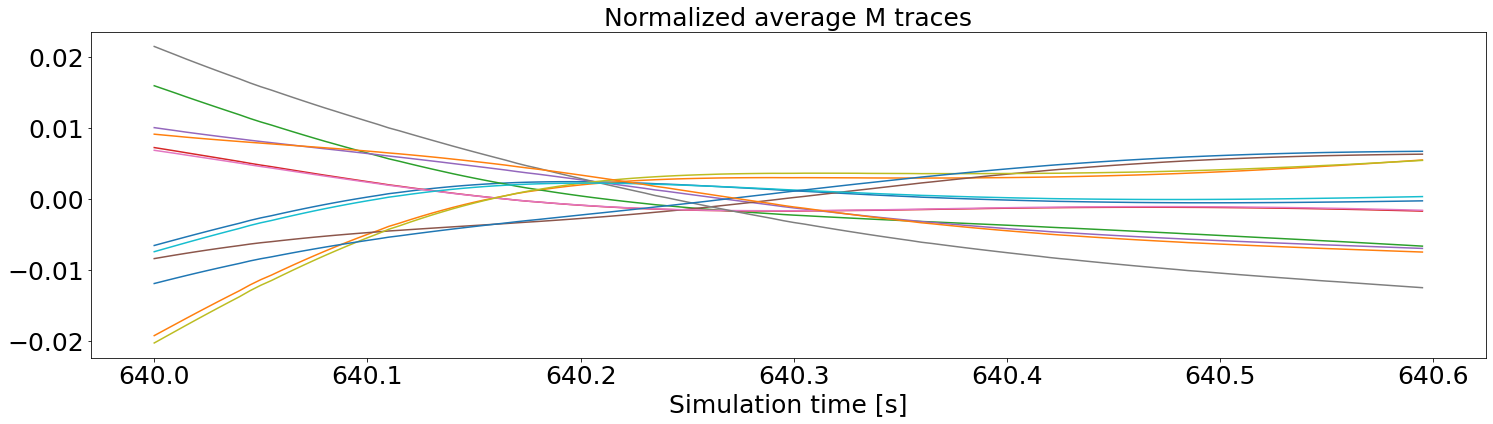

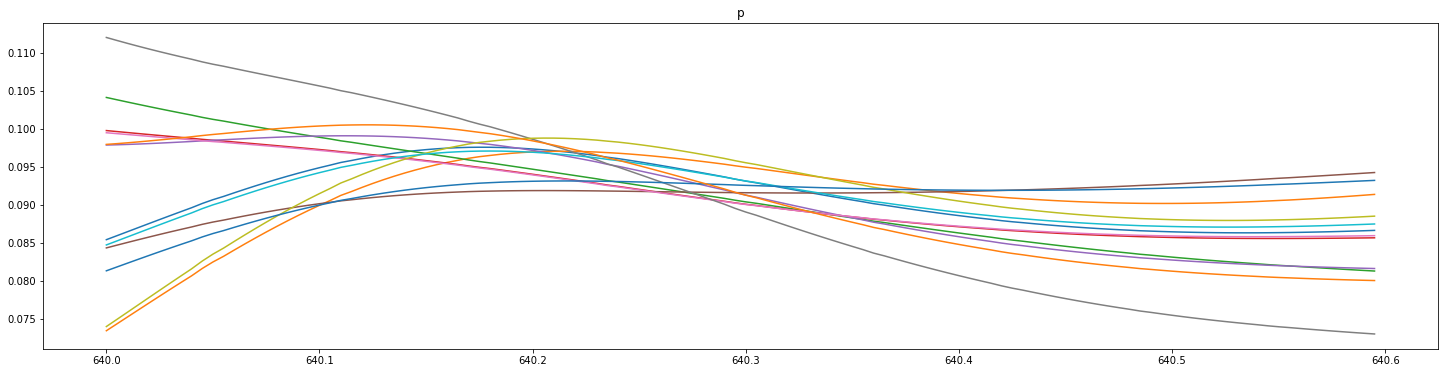

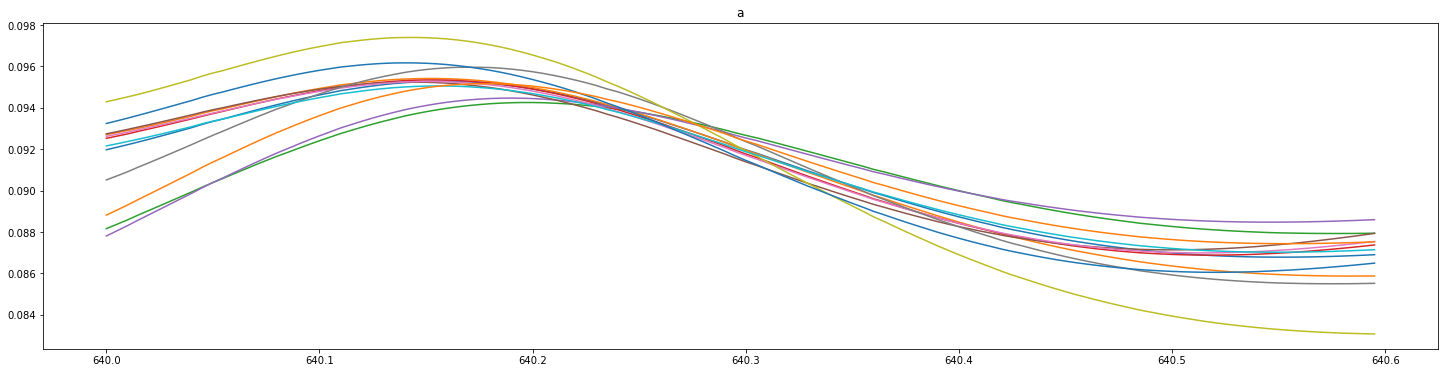

In [38]:
munit = 0
# trg_fig = plt.figure(figsize=fs)
# plt.plot(times[:T], m_tensor[munit,5,0,:])

# M_fig = plt.figure(figsize=fs)
# # M_data = np.array(data[M])
# # plt.plot(times[:T], M_data[munit,:T])
# plt.plot(times[pt_per_pres:pt_per_pres+T], data[M[0], pt_per_pres:pt_per_pres+T])

c_fig = plt.figure(figsize=fs)
plt.plot(times[:T], c_tensor[:,6,:].transpose())
plt.title("Normalized average M traces", fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
plt.xlabel('Simulation time [s]', fontsize=lab_s)

p_fig = plt.figure(figsize=fs)
plt.plot(times[:T], p_tensor[:,6,:].transpose())
plt.title("p")

a_fig = plt.figure(figsize=fs)
plt.plot(times[:T], a_tensor[:,:].transpose())
plt.title("a")

plt.show()

(0.0, 60.0)

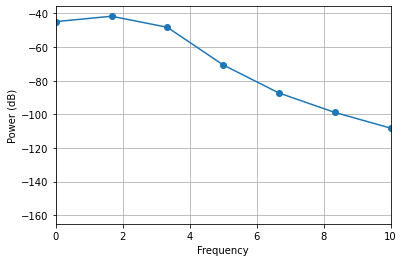

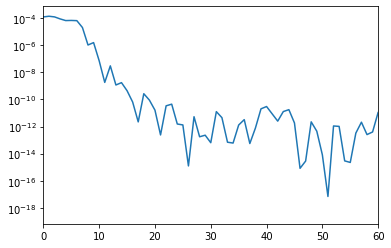

In [39]:
# power spectrum
from spectrum import *
fig1 = plt.figure()
spec_data = a_tensor[2, :]
spec_data = spec_data - np.mean(spec_data)
p = Periodogram(spec_data, sampling=(1./net.min_delay))
p.plot(marker='o')
plt.xlim([0,10])

fig2 = plt.figure()
res = pmtm(spec_data, NW=2.5, k=4, show=True)
plt.xlim([0,int(len(spec_data)/2)])

In [40]:
# jPCA analysis part 2

import scipy as sp
# Obtain the plane of strongest rotation

X = np.zeros((J*T,I))
for j in range(J):
    X[j*T:(j+1)*T, :] = c_tensor[:,j,:].transpose()

# create the block-matrix version of X
Xtilde = sp.linalg.block_diag(*([X]*I))

# Create the H matrix
n = X.shape[1]
ct = X.shape[0]
L = np.zeros((n,n), dtype=int)
c = 0
for row in range(n):
    for col in range(row+1, n):
        L[row, col] = c
        L[col, row] = c
        c += 1
        
H = np.zeros((n*n, int(0.5*n*(n-1))))
for col in range(n):
    for row in range(n):
        if col > row:
            H[n*col+row, L[col,row]] = 1.
        elif row > col:
            H[n*col+row, L[col,row]] = -1.
            
# Approximate the derivatives of X
Xp = np.zeros_like(X)
t_bit = times[1] - times[0]
Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

xp = Xp.flatten('F')

kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

# reconstruct the matrix that generated the data
Mstar = np.matmul(H, kstar).reshape(n,n)

# Next,extract the eigenvalues of M.
eig_vals, eig_vecs = np.linalg.eig(Mstar)
# print(Mstar)
# print("Eigenvalues: ")
# print(eig_vals)
# print("Eigenvectors: ")
# print(eig_vecs)

eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
ev_sum = eig_vals_norms.sum()/2.
var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
print("Variance percentages by each conjugate eigenvalue pair")
print(var_percentages)

# We obtain the plane of strongest rotations
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)


Variance percentages by each conjugate eigenvalue pair
[0.29489139 0.23673785 0.18933109]


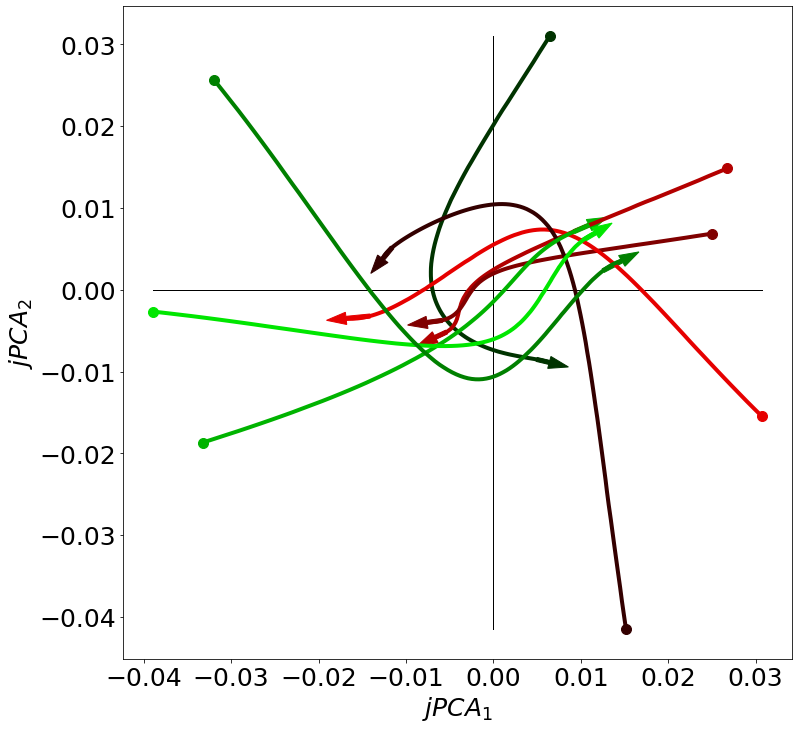

In [41]:
# jPCA analysis part 3

#n_pts = int(t_smp / net.min_delay)
n_pts = 100 # number of points in the trace to plot
# project activities into the plane of strongest rotations
jPCA1_traces = np.zeros((J, T), dtype=np.float_)
jPCA2_traces = np.zeros((J, T), dtype=np.float_)
u1 = u1.reshape(1,I)
u2 = u2.reshape(1,I)

for target in range(J):
    jPCA1_traces[target, :] = np.matmul(u1, c_tensor[:,target,:])
    jPCA2_traces[target, :] = np.matmul(u2, c_tensor[:,target,:])

    
# RGB colormap. First entry is greenest, last is reddest
cmap = [[0., .9, 0.],
        [0., .7, 0.],
        [0., .5, 0.],
        [0., .2, 0.],
        [.2, 0., 0.],
        [.5, 0., 0.],
        [.7, 0., 0.],
        [.9, 0., 0.]]
t0_jPC1s = [jPCA1_traces[target,0] for target in range(J)]
jPC1_sortr = list(np.argsort(t0_jPC1s))
#t0_jPC1s.sort() # sorting according to initial jPC1 component
jpca_fig =  plt.figure(figsize=(12,12))
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
y_span = [min(jPCA2_traces.flatten()), max(jPCA2_traces.flatten())]
x_span = [min(jPCA1_traces.flatten()), max(jPCA1_traces.flatten())]
plt.plot([0.,0.], y_span, 'k', linewidth=1)
plt.plot(x_span, [0., 0.], 'k', linewidth=1)
plt.xlabel('$jPCA_1$', fontsize=lab_s)
plt.ylabel('$jPCA_2$', fontsize=lab_s)
for target in range(J):
    c = cmap[jPC1_sortr.index(target)]
    plt.plot(jPCA1_traces[target,:n_pts], jPCA2_traces[target,:n_pts], color=c, linewidth=4)
    plt.scatter(jPCA1_traces[target,0], jPCA2_traces[target,0], s=100, color=c)
    dx = jPCA1_traces[target,n_pts] - jPCA1_traces[target,n_pts-10]
    dy = jPCA2_traces[target,n_pts] - jPCA2_traces[target,n_pts-10]
    plt.arrow(jPCA1_traces[target,n_pts-10],jPCA2_traces[target,n_pts-10],
             dx, dy, color=c, width=0.0005)

plt.show()

orthogonal fraction:0.209375


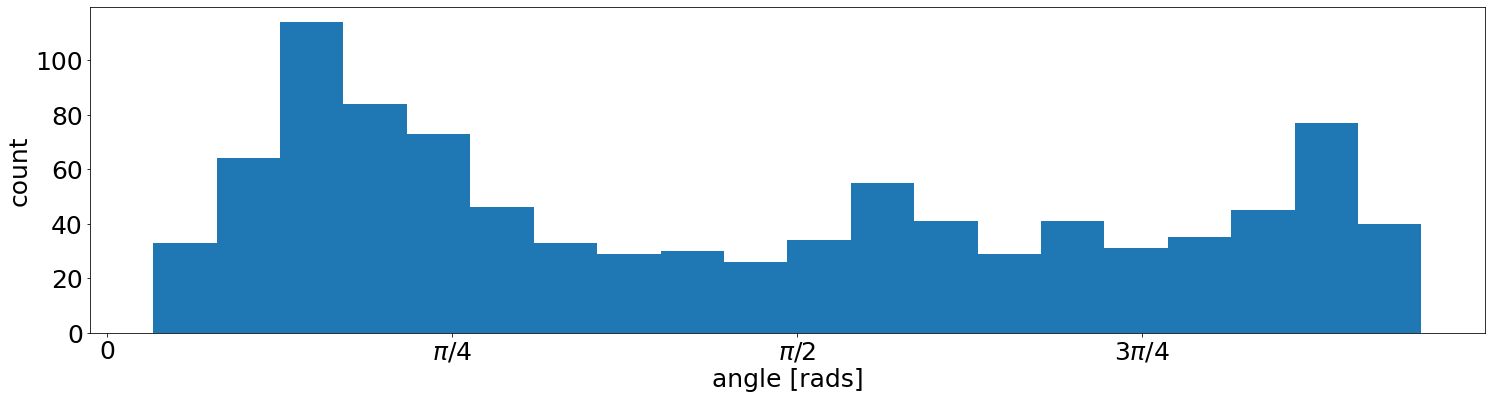

R2 unconstrained: 0.078824
R2 skew symmetric: -0.031213


In [42]:
# jPCA part 4
# Other measures of rotation

# 1) average angle between X and Xp
X_norms = np.linalg.norm(X, axis=1)
Xp_norms = np.linalg.norm(Xp, axis=1)
X_cos = (X * Xp).sum(axis=1) / (X_norms * Xp_norms + 1e-10)
X_angs = np.arccos(X_cos)

wid = 0.4 # widgth of window around pi/2 where X,Xp are "orthogonal"
orth_fr = ((X_angs < np.pi/2+wid) & (X_angs > np.pi/2-wid)).sum() / len(X_angs)
print("orthogonal fraction:%f" % (orth_fr))
n_bins = 20
hist_fig = plt.figure(figsize=fs)
plt.hist(X_angs, bins=n_bins)
plt.xticks(ticks=[0., np.pi/4, np.pi/2, 3.*np.pi/4.],
          labels=['0', '$\pi/4$', '$\pi/2$', '$3 \pi/4$'], fontsize=tic_s)
plt.yticks(fontsize=tic_s)
plt.xlabel('angle [rads]', fontsize=lab_s)
plt.ylabel('count', fontsize=lab_s)
plt.show()

# 2) Coefficients of determination
# 2.1) Obtain unconstrained M matrix
M_uncons = np.matmul(np.linalg.pinv(X), Xp)
# 2.2) Reconstruct Xp with M_uncons
Xp_uncons = np.matmul(X, M_uncons)
# 2.3) Reconstruct Xp with Mstar
Xp_skew = np.matmul(X, Mstar)
# 2.4) Calculate residual sums of squares
SSres_uncons = ((Xp - Xp_uncons) * (Xp - Xp_uncons)).sum()
SSres_skew = ((Xp - Xp_skew) * (Xp - Xp_skew)).sum()
# 2.5) Calculate the total sum of squares
SStot = ((Xp-Xp.mean())*(Xp-Xp.mean())).sum()
# 2.6) Calculate coefficients of determination
R2_uncons = 1. - (SSres_uncons / SStot)
R2_skew = 1. - (SSres_skew / SStot)

print("R2 unconstrained: %f" % (R2_uncons))
print("R2 skew symmetric: %f" % (R2_skew))

In [43]:
# Circular dynamics analyisis in a function
def jpca_ana(pop, t_smp, t_strt, J=n_trgs, K=n_rounds, wid=0.3, normalize=True):
    """ Returns some measures relate to the level of circular dynamics.
    
        Args:
            pop: IDs of the units to be analyzed.
            t_smp: how many seconds will be included per reach.
            t_start: time after target presentation when sample begins.
            J: number of targets.
            K: number of presentations per target.
            wid: width of window around pi/2 where angles are "orthogonal".
            normalize: if True, the population responses are normalized.
        Returns:
            A dictionary with the following entries:
            'var_per':array with variance percentages for the 3 jPCA planes.
            'orth_fr': fraction of "orthogonal" angles between X, Xp
            'R2_uncons': coefficent of determination for unconstrained model
            'R2_skew:: Coef. of Det. for skew-symmetric model.
            't_smp': the t_smp argument.
            't_strt': the t_strt argument.
    """
    idx_strt = int(t_strt / net.min_delay)
    I = len(pop)
    T = int(t_smp / net.min_delay) # number of time points
    m_tensor = get_pop_tensor(M[:I], J=J, K=K, t_smp=t_smp, t_strt=t_strt)
    
    # Normalize responses in m_tensor
    if normalize:
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    norm = np.linalg.norm(m_tensor[i,j,k,:])
                    m_tensor[i,j,k,:] = m_tensor[i,j,k,:] / norm
                
    # Now we average across repetitions for the same target
    p_tensor = m_tensor.sum(axis=2) / K

    # We obtain the across-condition average
    a_tensor = p_tensor.sum(axis=1) / J

    # Obtained a normalized average trace per condition
    c_tensor = np.zeros_like(p_tensor)
    for trg in range(J):
        c_tensor[:, trg, :] = p_tensor[:, trg, :] - a_tensor
    X = np.zeros((J*T,I))
    for j in range(J):
        X[j*T:(j+1)*T, :] = c_tensor[:,j,:].transpose()
    # create the block-matrix version of X
    Xtilde = sp.linalg.block_diag(*([X]*I))
    # Create the H matrix
    n = X.shape[1]
    ct = X.shape[0]
    L = np.zeros((n,n), dtype=int)
    c = 0
    for row in range(n):
        for col in range(row+1, n):
            L[row, col] = c
            L[col, row] = c
            c += 1
    H = np.zeros((n*n, int(0.5*n*(n-1))))
    for col in range(n):
        for row in range(n):
            if col > row:
                H[n*col+row, L[col,row]] = 1.
            elif row > col:
                H[n*col+row, L[col,row]] = -1.
    # Approximate the derivatives of X
    Xp = np.zeros_like(X)
    t_bit = times[1] - times[0]
    Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit
    xp = Xp.flatten('F')
    kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)
    # reconstruct the matrix that generated the data
    Mstar = np.matmul(H, kstar).reshape(n,n)
    # Next,extract the eigenvalues of M.
    eig_vals, eig_vecs = np.linalg.eig(Mstar)
    eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
    ev_sum = eig_vals_norms.sum()/2.
    var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
    
    # 1) average angle between X and Xp
    X_norms = np.linalg.norm(X, axis=1)
    Xp_norms = np.linalg.norm(Xp, axis=1)
    X_cos = (X * Xp).sum(axis=1) / (X_norms * Xp_norms + 1e-10)
    X_angs = np.arccos(X_cos)

    orth_fr = ((X_angs < np.pi/2+wid) & (X_angs > np.pi/2-wid)).sum() / len(X_angs)

    # 2) Coefficients of determination
    # 2.1) Obtain unconstrained M matrix
    M_uncons = np.matmul(np.linalg.pinv(X), Xp)
    # 2.2) Reconstruct Xp with M_uncons
    Xp_uncons = np.matmul(X, M_uncons)
    # 2.3) Reconstruct Xp with Mstar
    Xp_skew = np.matmul(X, Mstar)
    # 2.4) Calculate residual sums of squares
    SSres_uncons = ((Xp - Xp_uncons) * (Xp - Xp_uncons)).sum()
    SSres_skew = ((Xp - Xp_skew) * (Xp - Xp_skew)).sum()
    # 2.5) Calculate the total sum of squares
    SStot = ((Xp-Xp.mean())*(Xp-Xp.mean())).sum()
    # 2.6) Calculate coefficients of determination
    R2_uncons = 1. - (SSres_uncons / SStot)
    R2_skew = 1. - (SSres_skew / SStot)
    
    return {'var_per': var_percentages,
            'orth_fr': orth_fr,
            'R2_uncons': R2_uncons,
            'R2_skew': R2_skew,
            't_smp': t_smp,
            't_strt': t_strt}

In [44]:
# test a bunch of sampling windows for jPCA
grid_len = 50
t_smp_grid = np.linspace(0.1, 4., grid_len)
t_strt_grid = np.linspace(0., 1., grid_len)
jpca_anas_norm = []
vp_norm_grid = np.zeros((len(t_smp_grid), len(t_strt_grid)))
of_norm_grid = np.zeros((len(t_smp_grid), len(t_strt_grid)))
r2_norm_grid = np.zeros((len(t_smp_grid), len(t_strt_grid)))
for smp_idx, t_smp in enumerate(t_smp_grid):
    for strt_idx, t_strt in enumerate(t_strt_grid):
        jpca_anas_norm.append(jpca_ana(M[:I], t_smp, t_strt, normalize=True))
        vp_norm_grid[smp_idx, strt_idx] = jpca_anas_norm[-1]['var_per'][0]
        of_norm_grid[smp_idx, strt_idx] = jpca_anas_norm[-1]['orth_fr']
        r2_norm_grid[smp_idx, strt_idx] = jpca_anas_norm[-1]['R2_skew']
            
jpca_anas_unorm = []
vp_unorm_grid = np.zeros((len(t_smp_grid), len(t_strt_grid)))
of_unorm_grid = np.zeros((len(t_smp_grid), len(t_strt_grid)))
r2_unorm_grid = np.zeros((len(t_smp_grid), len(t_strt_grid)))
for smp_idx, t_smp in enumerate(t_smp_grid):
    for strt_idx, t_strt in enumerate(t_strt_grid):
        jpca_anas_unorm.append(jpca_ana(M[:I], t_smp, t_strt, normalize=False))
        vp_unorm_grid[smp_idx, strt_idx] = jpca_anas_unorm[-1]['var_per'][0]
        of_unorm_grid[smp_idx, strt_idx] = jpca_anas_unorm[-1]['orth_fr']
        r2_unorm_grid[smp_idx, strt_idx] = jpca_anas_unorm[-1]['R2_skew']

In [45]:
max_vp_smp, max_vp_strt = divmod(np.argmax(vp_norm_grid), grid_len)
max_of_smp, max_of_strt = divmod(np.argmax(of_norm_grid), grid_len)
max_vpof_smp, max_vpof_strt = divmod(np.argmax(vp_norm_grid*of_norm_grid), grid_len)
print("max vp: smp=%f, strt=%f" % (t_smp_grid[max_vp_smp], t_strt_grid[max_vp_strt]))
print("max of: smp=%f, strt=%f" % (t_smp_grid[max_of_smp], t_strt_grid[max_of_strt]))
print("max vpof: smp=%f, strt=%f" % (t_smp_grid[max_vpof_smp], t_strt_grid[max_vpof_strt]))

max vp: smp=0.736735, strt=0.040816
max of: smp=2.169388, strt=0.265306
max vpof: smp=2.248980, strt=0.285714


Results with normalized firing rates: 

Top three windows for var_per:
1) t_smp:0.736735, t_strt:0.040816, var_per:0.499461
2) t_smp:0.816327, t_strt:0.040816, var_per:0.496226
3) t_smp:0.657143, t_strt:0.040816, var_per:0.486004
Top three windows for orth_fr:
1) t_smp:2.169388, t_strt:0.265306, orth_fr:0.262413
2) t_smp:2.248980, t_strt:0.265306, orht_fr:0.260579
3) t_smp:2.248980, t_strt:0.244898, orth_fr:0.260579
Top three windows for R2_uncons-R2_skew:
1) t_smp:4.000000, t_strt:0.102041, R2_skew:-0.004803
2) t_smp:3.920408, t_strt:0.102041, R2_skew:-0.004857
3) t_smp:3.840816, t_strt:0.102041, R2_skew:-0.004912


Text(0, 0.5, 'start time')

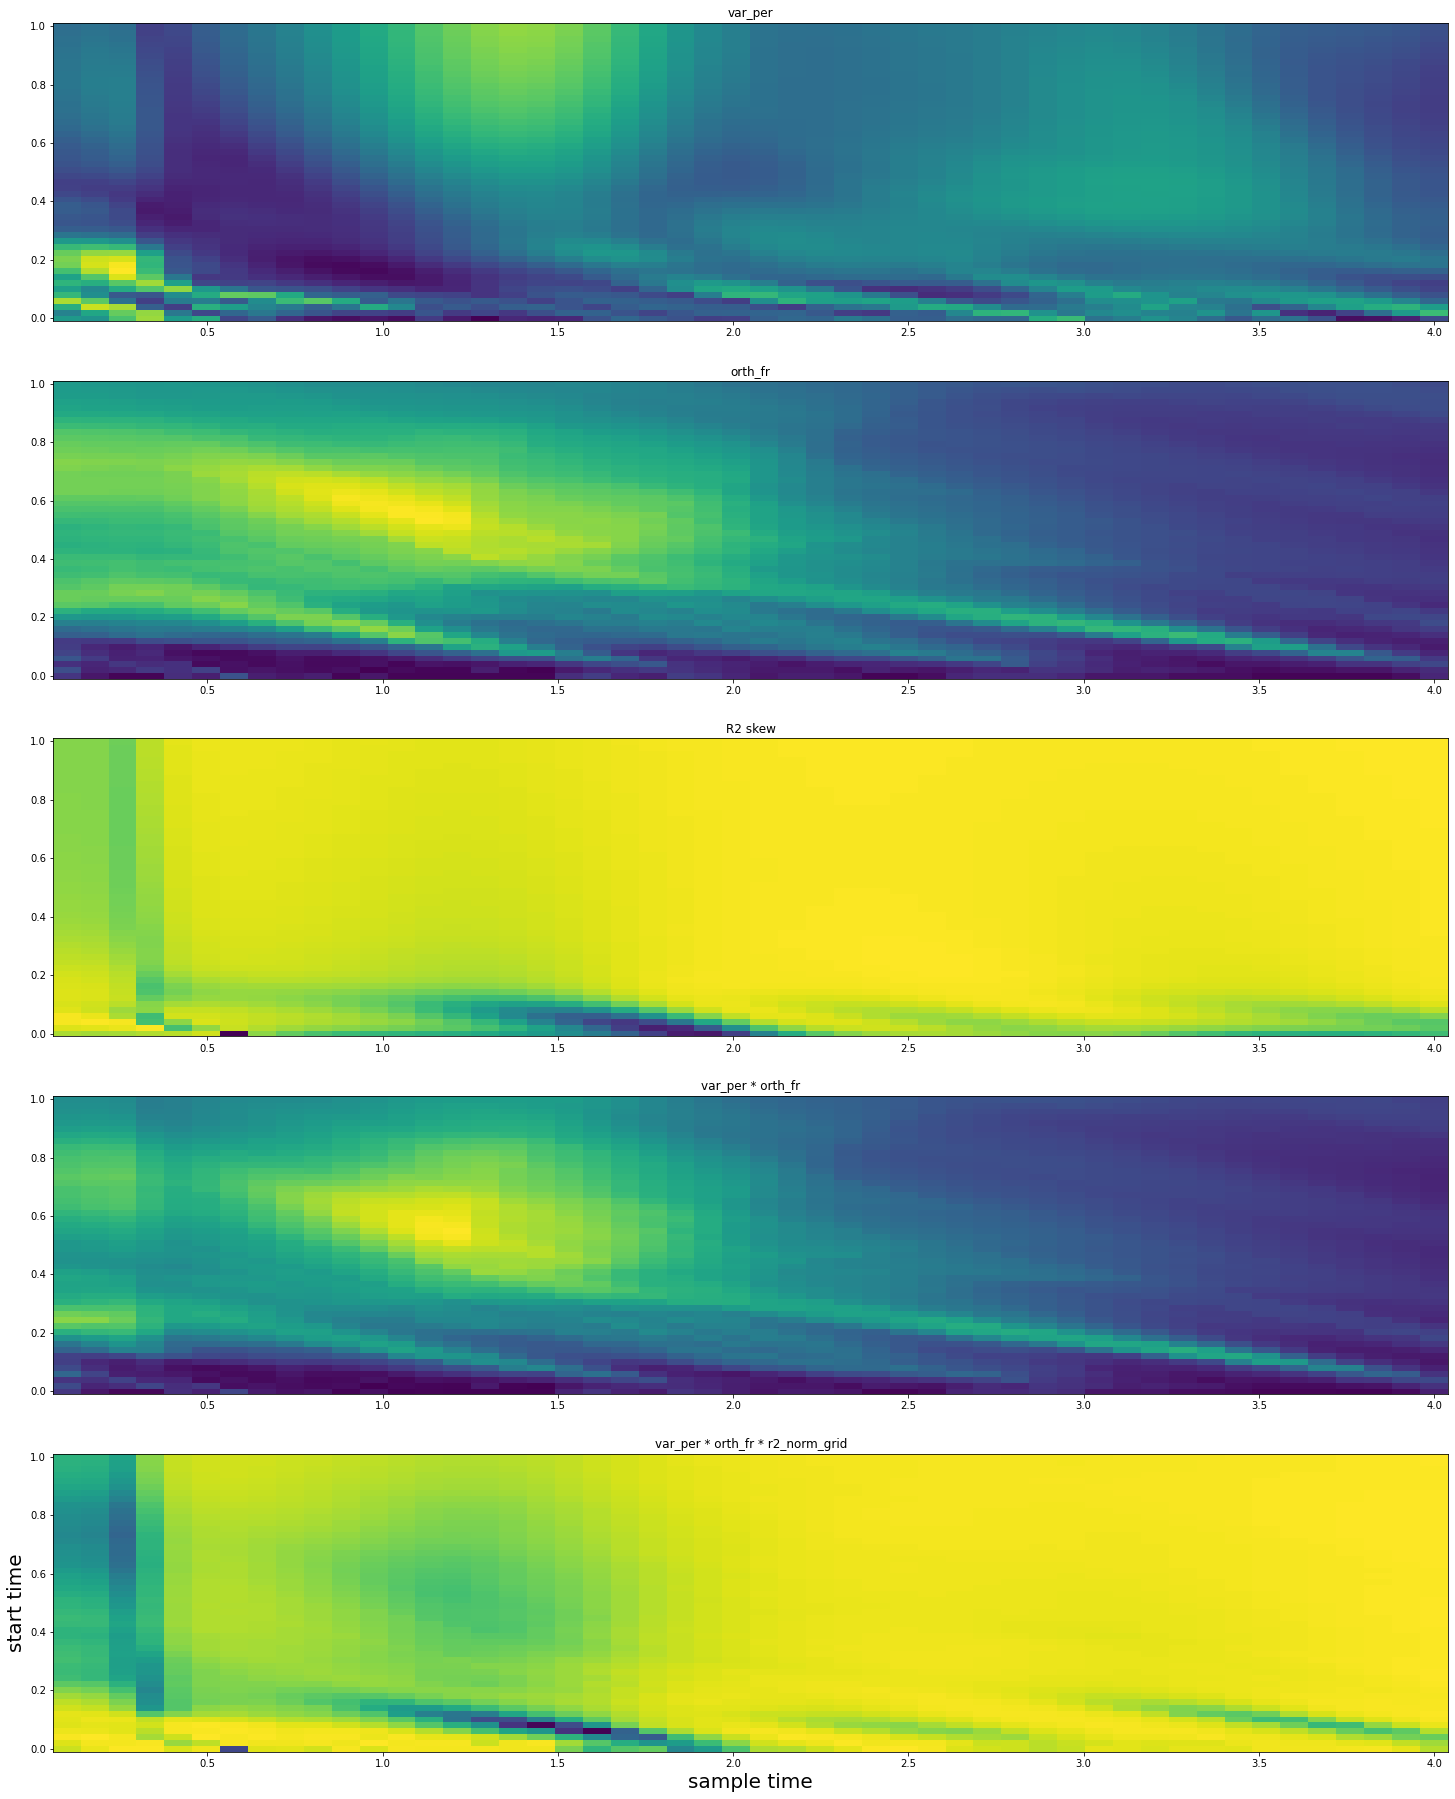

In [46]:
# results for normalized rates

# sort by highest variance percentage in the first jPCA plane
print("Results with normalized firing rates: ", end='\n\n')
jpca_anas_norm.sort(key = lambda x: -x['var_per'][0])
print("Top three windows for var_per:")
print("1) t_smp:%f, t_strt:%f, var_per:%f"  % 
      (jpca_anas_norm[0]['t_smp'], jpca_anas_norm[0]['t_strt'], jpca_anas_norm[0]['var_per'][0]))
print("2) t_smp:%f, t_strt:%f, var_per:%f"  %
      (jpca_anas_norm[1]['t_smp'], jpca_anas_norm[1]['t_strt'], jpca_anas_norm[1]['var_per'][0]))
print("3) t_smp:%f, t_strt:%f, var_per:%f"  %
      (jpca_anas_norm[2]['t_smp'], jpca_anas_norm[2]['t_strt'], jpca_anas_norm[2]['var_per'][0]))

# sort by highest fraction of orthogonal angles between X and Xp
jpca_anas_norm.sort(key = lambda x: -x['orth_fr'])
print("Top three windows for orth_fr:")
print("1) t_smp:%f, t_strt:%f, orth_fr:%f"  % 
      (jpca_anas_norm[0]['t_smp'], jpca_anas_norm[0]['t_strt'], jpca_anas_norm[0]['orth_fr']))
print("2) t_smp:%f, t_strt:%f, orht_fr:%f"  %
      (jpca_anas_norm[1]['t_smp'], jpca_anas_norm[1]['t_strt'], jpca_anas_norm[1]['orth_fr']))
print("3) t_smp:%f, t_strt:%f, orth_fr:%f"  %
      (jpca_anas_norm[2]['t_smp'], jpca_anas_norm[2]['t_strt'], jpca_anas_norm[2]['orth_fr']))

# sort by best reconstruction
jpca_anas_norm.sort(key = lambda x: x['R2_uncons']-x['R2_skew'])
print("Top three windows for R2_uncons-R2_skew:")
print("1) t_smp:%f, t_strt:%f, R2_skew:%f"  % 
      (jpca_anas_norm[0]['t_smp'], jpca_anas_norm[0]['t_strt'], jpca_anas_norm[0]['R2_skew']))
print("2) t_smp:%f, t_strt:%f, R2_skew:%f"  %
      (jpca_anas_norm[1]['t_smp'], jpca_anas_norm[1]['t_strt'], jpca_anas_norm[1]['R2_skew']))
print("3) t_smp:%f, t_strt:%f, R2_skew:%f"  %
      (jpca_anas_norm[2]['t_smp'], jpca_anas_norm[2]['t_strt'], jpca_anas_norm[2]['R2_skew']))

# plot results
norm_fig, norm_axs = plt.subplots(5, 1, figsize=(fs[0], 5.3*fs[1]))
norm_axs[0].pcolormesh(t_smp_grid, t_strt_grid, vp_norm_grid, shading='auto')
norm_axs[0].set_title('var_per')

norm_axs[1].pcolormesh(t_smp_grid, t_strt_grid, of_norm_grid, shading='auto')
norm_axs[1].set_title('orth_fr')

norm_axs[2].pcolormesh(t_smp_grid, t_strt_grid, r2_norm_grid, shading='auto')
norm_axs[2].set_title('R2 skew')

norm_axs[3].pcolormesh(t_smp_grid, t_strt_grid, of_norm_grid*vp_norm_grid, shading='auto')
norm_axs[3].set_title('var_per * orth_fr')

norm_axs[4].pcolormesh(t_smp_grid, t_strt_grid, of_norm_grid*vp_norm_grid*r2_norm_grid, shading='auto')
norm_axs[4].set_title('var_per * orth_fr * r2_norm_grid')
norm_axs[4].set_xlabel('sample time', fontsize=20)
norm_axs[4].set_ylabel('start time', fontsize=20)

Results with unnormalized firing rates: 

Top three windows for var_per:
1) t_smp:0.100000, t_strt:0.102041, var_per:0.584864
2) t_smp:0.497959, t_strt:0.040816, var_per:0.581356
3) t_smp:0.259184, t_strt:0.285714, var_per:0.572142
Top three windows for orth_fr:
1) t_smp:0.100000, t_strt:0.448980, orth_fr:0.150000
2) t_smp:0.100000, t_strt:0.428571, orht_fr:0.150000
3) t_smp:0.100000, t_strt:0.408163, orth_fr:0.150000
Top three windows for R2_uncons-R2_skew:
1) t_smp:4.000000, t_strt:0.714286, R2_skew:-0.001374
2) t_smp:4.000000, t_strt:0.734694, R2_skew:-0.001374
3) t_smp:3.920408, t_strt:0.714286, R2_skew:-0.001389


Text(0, 0.5, 'start time')

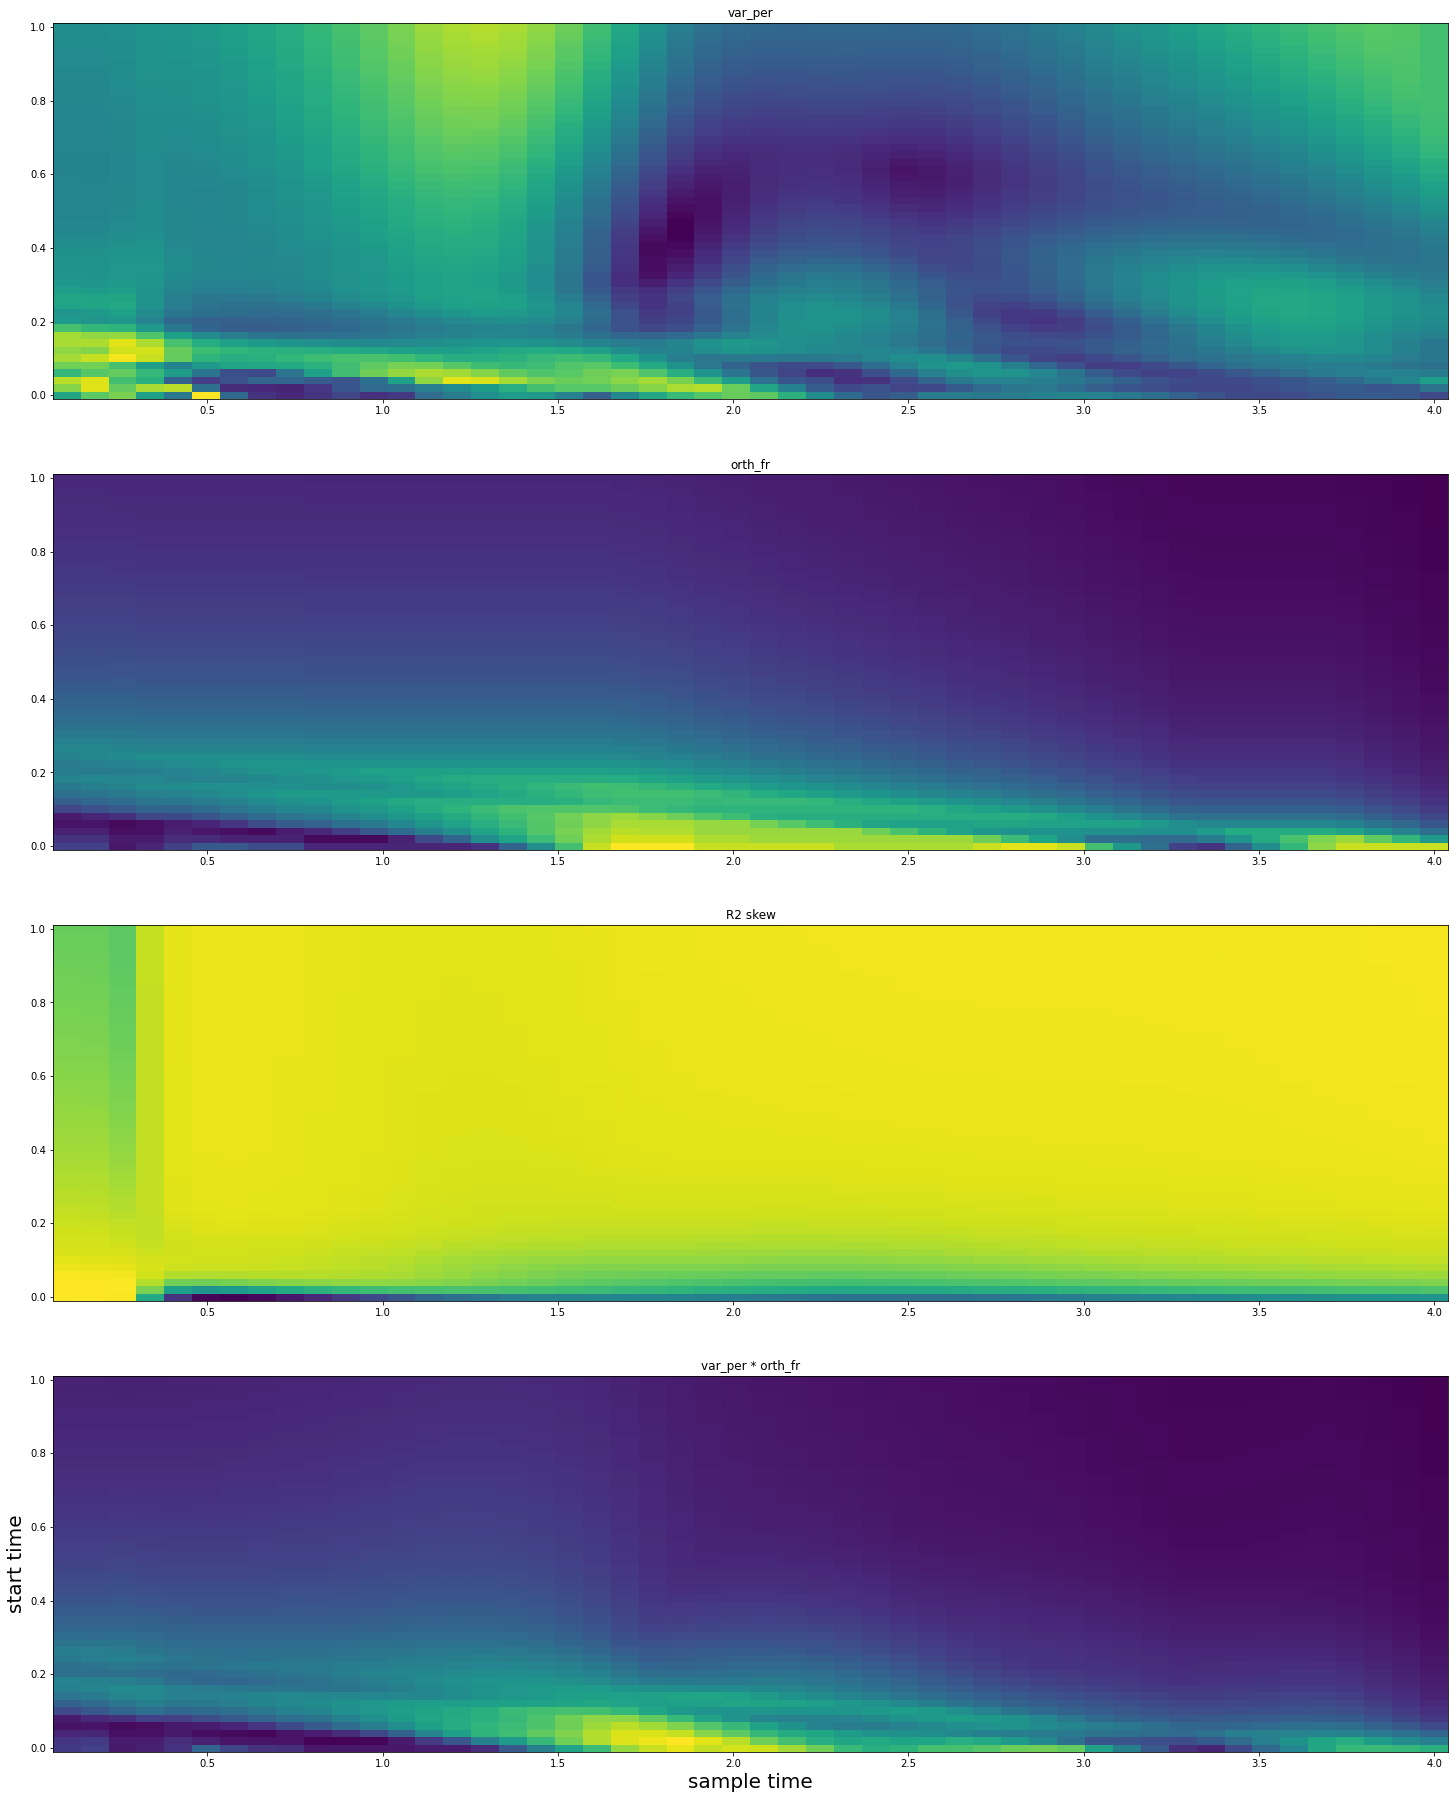

In [47]:
# results for unnormalized rates

# sort by highest variance percentage in the first jPCA plane
print("Results with unnormalized firing rates: ", end='\n\n')
jpca_anas_unorm.sort(key = lambda x: -x['var_per'][0])
print("Top three windows for var_per:")
print("1) t_smp:%f, t_strt:%f, var_per:%f"  % 
      (jpca_anas_unorm[0]['t_smp'], jpca_anas_unorm[0]['t_strt'], jpca_anas_unorm[0]['var_per'][0]))
print("2) t_smp:%f, t_strt:%f, var_per:%f"  %
      (jpca_anas_unorm[1]['t_smp'], jpca_anas_unorm[1]['t_strt'], jpca_anas_unorm[1]['var_per'][0]))
print("3) t_smp:%f, t_strt:%f, var_per:%f"  %
      (jpca_anas_unorm[2]['t_smp'], jpca_anas_unorm[2]['t_strt'], jpca_anas_unorm[2]['var_per'][0]))

# sort by highest fraction of orthogonal angles between X and Xp
jpca_anas_unorm.sort(key = lambda x: -x['orth_fr'])
print("Top three windows for orth_fr:")
print("1) t_smp:%f, t_strt:%f, orth_fr:%f"  % 
      (jpca_anas_unorm[0]['t_smp'], jpca_anas_unorm[0]['t_strt'], jpca_anas_unorm[0]['orth_fr']))
print("2) t_smp:%f, t_strt:%f, orht_fr:%f"  %
      (jpca_anas_unorm[1]['t_smp'], jpca_anas_unorm[1]['t_strt'], jpca_anas_unorm[1]['orth_fr']))
print("3) t_smp:%f, t_strt:%f, orth_fr:%f"  %
      (jpca_anas_unorm[2]['t_smp'], jpca_anas_unorm[2]['t_strt'], jpca_anas_unorm[2]['orth_fr']))

# sort by best reconstruction
jpca_anas_unorm.sort(key = lambda x: x['R2_uncons']-x['R2_skew'])
print("Top three windows for R2_uncons-R2_skew:")
print("1) t_smp:%f, t_strt:%f, R2_skew:%f"  % 
      (jpca_anas_unorm[0]['t_smp'], jpca_anas_unorm[0]['t_strt'], jpca_anas_unorm[0]['R2_skew']))
print("2) t_smp:%f, t_strt:%f, R2_skew:%f"  %
      (jpca_anas_unorm[1]['t_smp'], jpca_anas_unorm[1]['t_strt'], jpca_anas_unorm[1]['R2_skew']))
print("3) t_smp:%f, t_strt:%f, R2_skew:%f"  %
      (jpca_anas_unorm[2]['t_smp'], jpca_anas_unorm[2]['t_strt'], jpca_anas_unorm[2]['R2_skew']))

# plot results
unorm_fig, unorm_axs = plt.subplots(4, 1, figsize=(fs[0], 5.3*fs[1]))
unorm_axs[0].pcolormesh(t_smp_grid, t_strt_grid, vp_unorm_grid, shading='auto')
unorm_axs[0].set_title('var_per')

unorm_axs[1].pcolormesh(t_smp_grid, t_strt_grid, of_unorm_grid, shading='auto')
unorm_axs[1].set_title('orth_fr')

unorm_axs[2].pcolormesh(t_smp_grid, t_strt_grid, r2_unorm_grid, shading='auto')
unorm_axs[2].set_title('R2 skew')

unorm_axs[3].pcolormesh(t_smp_grid, t_strt_grid, of_unorm_grid*vp_unorm_grid, shading='auto')
unorm_axs[3].set_title('var_per * orth_fr')
unorm_axs[3].set_xlabel('sample time', fontsize=20)
unorm_axs[3].set_ylabel('start time', fontsize=20)

---
## Second direction tuning analysis (PD drift)
---

In [ ]:
# set new targets with the function

n_rounds = 10
n_trgs = 10 # more targets!

start_t = net.sim_time # starting time for new simulation
hand_coords, targets, center, trg_ids, m_idxs = set_new_targets(net, 
                                                          pops_dict,
                                                                  r, 
                                                             t_pres,
                                                             n_trgs, 
                                                           n_rounds,
                                                                pds)

In [ ]:
# Run simulation for radial reaches
sim_time2 = 2 * t_pres * n_trgs * n_rounds
start_wctime = time.time()
times, data, plant_data  = net.flat_run(sim_time2)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_wctime))

In [ ]:
# Obtain hand error
arm_activs = plant_data[P]
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t+1e-8)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
    
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)

In [ ]:
# Arrange the error data into a tensor
# he_tensor[j,k,t] is the hand tensor for target j,
# o the k-th presentation, at time t
J = n_trgs # number of targets
K = n_rounds # number of repetitions per target
T = int(round(t_pres / net.min_delay)) # number of time points

he_tensor = get_tensor(hand_error, J=J, K=K, T=T)
# he_tensor = np.zeros((J, K, T))
# trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
# #pt_per_pres = int(round(t_pres / net.min_delay))
# for reach, trg in enumerate(trg_ids):
#     init_tid = (1 + 2 * reach) * T
#     final_tid = init_tid + T # t_pres seconds later
#     he_tensor[trg, trg_reps[trg],:] = hand_error[init_tid:final_tid]
#     trg_reps[trg] += 1
    
# we average across repetitions of the same target
ahe_trg = he_tensor.sum(axis=1) / K

# we average across all reaches
ahe = ahe_trg.sum(axis=0) / J

In [ ]:
# Print distance to target for each target
ahe_fig = plt.figure(figsize=fs)
reach_ts = np.linspace(0., t_pres, T)
plt.plot(reach_ts, ahe, linewidth=4)
plt.title("Distance to target (average across all targets)", fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

n_rows = 2
n_cols = 4
ahe_trg_fig, ahe_trg_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], 2*fs[1]), sharey=True)
for row in range(n_rows):
    for col in range(n_cols):
        ax = ahe_trg_axs[row,col]
        trg = row*n_cols + col
        ax.plot(reach_ts, ahe_trg[trg, :], linewidth=4)
        ax.tick_params(axis='both', labelsize=tic_s)
        ax.set_title("target " + str(trg), fontsize=tit_s)
        for rep in range(K):
            ax.plot(reach_ts, he_tensor[trg,rep,:], '--', linewidth=1, color='b')

plt.show()

In [ ]:
# Obtain hand coordinates through time
from numpy import cos, sin
if not 'targets' in locals():
    targets = np.array([[0.3, 0.3]])

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
ipx = data[ipx_track,:]
ipy = data[ipy_track,:]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2

# placing hand coordinates in tensors (arrange by target, repetition)
xh_tensor = get_tensor(xh, J=J, K=K, T=T)
yh_tensor = get_tensor(yh, J=J, K=K, T=T)

# xh_tensor = np.zeros((J, K, T))
# yh_tensor = np.zeros((J, K, T))
# trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
# for reach, trg in enumerate(trg_ids):
#     init_tid = (1 + 2 * reach) * T
#     final_tid = init_tid + T
#     xh_tensor[trg, trg_reps[trg], :] = xh[init_tid:final_tid]
#     yh_tensor[trg, trg_reps[trg], :] = yh[init_tid:final_tid]
#     trg_reps[trg] += 1
    
# average across reptitions of the same target
axh_trg = xh_tensor.sum(axis=1) / K
ayh_trg = yh_tensor.sum(axis=1) / K

In [ ]:
# Obtain velocity profile for the reaches
xph = np.concatenate(([0], (xh[1:] - xh[:-1]) / net.min_delay))
yph = np.concatenate(([0], (yh[1:] - yh[:-1]) / net.min_delay))
hv = np.sqrt(xph*xph + yph*yph)

hv_tensor = get_tensor(hv, J=J, K=K, T=T)

# we average across repetitions of the same target
ahv_trg = hv_tensor.sum(axis=1) / K

# we average across all reaches
ahv = ahv_trg.sum(axis=0) / J

In [ ]:
# Print velocity for each target
ahv_fig = plt.figure(figsize=fs)
reach_ts = np.linspace(0., t_pres, T)
plt.plot(reach_ts, ahv, linewidth=4)
plt.title("hand velocity (average across all targets)", fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
plt.ylabel('velocity [m/s]', fontsize=lab_s)
plt.xlabel('time [s]', fontsize=lab_s)


n_rows = 2
n_cols = 4
ahv_trg_fig, ahv_trg_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], 2*fs[1]), sharey=True)
for row in range(n_rows):
    for col in range(n_cols):
        ax = ahv_trg_axs[row,col]
        trg = row*n_cols + col
        ax.plot(reach_ts, ahv_trg[trg, :], linewidth=4)
        ax.tick_params(axis='both', labelsize=tic_s)
        ax.set_title("target " + str(trg), fontsize=tit_s)
        for rep in range(K):
            ax.plot(reach_ts, hv_tensor[trg,rep,:], '--', linewidth=1, color='b')
        if col==0:
            ax.set_ylabel('velocity [m/s]', fontsize=lab_s)

plt.show()

In [ ]:
# plot average reach trajectories and some individual reaches
n_ind_reaches = 4 # number of example reaches to plot
reach_fig = plt.figure(figsize=(10,10))
reach_ax = plt.gca()
trial = 0
#reach_ax.scatter(targets[:,0], targets[:,1], s=1000, c='cyan')
reach_ax.scatter(center[0]+.8*(targets[:,0]-center[0]), 
                 center[1]+.8*(targets[:,1]-center[1]), s=1000, c='k', alpha=0.3)
#reach_ax.scatter(.6*(targets[:,0]+center[0]), .6*(targets[:,1]+center[1]), s=1000, c='cyan', alpha=0.4)
reach_ax.scatter(center[0], center[1], s=2000, c='blue')
plt.axis('equal')
reach_ax.grid()
cmap = [[0.1, 0.4, 0.8, 0.5],
        [0.2, 0.2, 0.2, 0.8],
        [0.9, 0.7, 0.2, 0.8],
        [0.1, 0.7, 0.1, 0.6],
        [0.9, 0.1, 0.1, 0.5],
        [0.6, 0.2, 0.6, 0.5],
        [0.8, 0.4, 0.1, 0.5],
        [0.7, 0.1, 0.7, 0.5],
        [0.5, 0.5, 0.2, 0.8],
        [0.3, 0.3, 0.3, 0.5]]
for trg in range(J):
    reach_ax.plot(axh_trg[trg,:], ayh_trg[trg,:], linewidth=3, color=cmap[trg])
    for rep in range(min(n_ind_reaches, K)):
        reach_ax.plot(xh_tensor[trg, rep, :], yh_tensor[trg, rep, :], '--', linewidth=1, color=cmap[trg])
#from IPython.display import Image
#Image(filename='temp_fig')
#plt.savefig('temp_fig2')
plt.show()

In [ ]:
# Obtaining the prefered directions for the units in M
# Find the mean rate for each target
t_smp = 1. # time to sample M (in seconds)
I = 12 # number of units to consider in M
m_tensor = get_pop_tensor(M[:I], J=J, K=K, t_smp=t_smp, trg_ids=trg_ids)
# m_tensor[i,j,k,t] is the activity of the i-th M 
# unit for target j, on the k-th repetition, at time point t.

# Now we average across repetitions for the same target
m_tensor_trg_avg = m_tensor.sum(axis=2) / K
# m_tensor_trg_avg[i,j,t]: average activity of i-th M unit when
# reaching for target j, at time point t

m_avg_rates = np.zeros((I,J)) # average rate at each unit for each target
for trg in range(J):
    m_avg_rates[:, trg] = np.mean(m_tensor_trg_avg[:, trg, :], axis=1)

m_means = np.mean(m_avg_rates, axis=1) # mean rate for each unit
    
# Obtaining preferred directions by fitting the rates using a plane, and using
# the angle of the projection of this plane's normal vector onto the XY plane
# The coefficients of the normal vector can be calculated using the least-squares
# method, which leads to a 3x3 linear system that is readily reduced to a 2x2 system.
trgs = targets - center # targets centered at the origin
xs = trgs[:,0]
ys = trgs[:,1]
cxs = xs - np.mean(xs) # "centered" x coordinates
cys = ys - np.mean(ys) #  "centered" Y coordinates

X11 = (xs * cxs).sum()
X12 = (xs * cys).sum()
X21 = (ys * cxs).sum()
X22 = (ys * cys).sum()

Amat = np.array([[X11, X12], [X21, X22]])
detA = np.linalg.det(Amat) # determinant of Amat
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Amat)

prf_angsB = np.zeros(len(M)) # preferred angles, in radians
normal_vecsB = [] # list with the vectors normal to the plane fitting the rates

for uid in range(I):
    r1 = (xs * (m_avg_rates[uid, :] - m_means[uid])).sum()
    r2 = (ys * (m_avg_rates[uid, :] - m_means[uid])).sum()
    n = np.matmul(invA, np.array([r1,r2]))
    # boils down to
    #n = [a,b] where b = r2/X22, a = r1/X11
    #normal_vecsB.append(n / np.linalg.norm(n)) # appending normalized vector
    normal_vecsB.append(n)
    prf_angsB[uid] = np.arctan2(n[1], n[0]) # preferred angle
    #print("n1=%f, n0=%f, prf_ang=%f"%(n[1],n[0]))

    c = np.mean(m_avg_rates[uid,:] - n[0]*xs - n[1]*ys)
    
    # obtaining residuals, coefficient of determination, R^2
    residuals = m_avg_rates[uid,:] - n[0]*xs - n[1]*ys - c
    devs = m_avg_rates[uid,:] - m_means[uid]
    SSr = (residuals * residuals).sum()
    SSt = (devs * devs).sum()
    R = 1. - (SSr/SSt)
    print(R)

normal_vecsB = np.array(normal_vecsB)

# Get the lengths of the preferred direction vectors
pd_normsB = np.linalg.norm(normal_vecsB, axis=1)

In [ ]:
# Plot direction tuning for all M units

dir_fig, dir_axs = plt.subplots(3, 4, figsize=(fs[0], 3.3*fs[1]))


for row in range(3):
    for col in range(4):
        ax = dir_axs[row][col]
        m_id = 4*row + col
        span = max(np.linalg.norm(normal_vecs[m_id]), np.linalg.norm(normal_vecsB[m_id]))
        ax.set_xlim([-1.1*span, 1.1*span])
        ax.set_ylim([-1.1*span, 1.1*span])
        ax.grid()
        ax.set_title("M = %d" % (m_id), fontsize=tit_s)
        ax.tick_params(axis='both', labelsize=tic_s)
        mod_trgs = m_avg_rates[m_id,:].reshape(n_trgs,1) * trgs 
        #for trg in range(J):
            #ax.plot([trgs[trg][0]], [trgs[trg][1]], '*')
            #ax.plot([0., mod_trgs[trg, 0]], [0., mod_trgs[trg, 1]], linewidth=5, color='b')
        #nrms = np.linalg.norm(mod_trgs, axis=1)
#         ax.plot([0., normal_vecs[m_id, 0]], [0., normal_vecs[m_id, 1]], linewidth=3, color='r')
#         ax.plot([0., normal_vecsB[m_id, 0]], [0., normal_vecsB[m_id, 1]], linewidth=3, color='b')
        nrm = np.linalg.norm(normal_vecs[m_id,:])
        ax.arrow(0., 0., normal_vecs[m_id, 0], normal_vecs[m_id, 1],
                 width=.03*nrm, color='r', length_includes_head=True)
        ax.arrow(0., 0., normal_vecsB[m_id, 0], normal_vecsB[m_id, 1],
                 width=.03*nrm, color='b', length_includes_head=True)
            
plt.show()

# plt.arrow(jPCA1_traces[target,n_pts-10],jPCA2_traces[target,n_pts-10],
#              dx, dy, color=c, width=0.0005)

In [ ]:
# Find average absolute value for deviations in the preferred directions
sig_indexes = [1,2,4,5,7,8,10,11]
mean_abs_ang_dev = np.mean(np.abs(prf_angs[sig_indexes] - prf_angsB[sig_indexes]))
print("Mean PD deviation (degrees): %f" % (mean_abs_ang_dev*180./np.pi))

In [48]:
print('Analysis time is %s seconds' % (time.time() - start_wctime))

Analysis time is 640.6366832256317 seconds


---
---
---
---

In [88]:
cfg

{'A__M_lrate': 20.0,
 'A__M_w_max_frac': 0.37538925125550265,
 'A__M_w_sum': 1.0,
 'AL_thresh': 0.5530557346059354,
 'b_e': 2.2051624234949543,
 'C__C_antag': 1.5510068153470922,
 'C__C_p_antag': 0.20412166302119808,
 'C__C_p_syne': 0.2772641822192721,
 'C__C_syne': 0.9686225337031041,
 'C_adapt_amp': 2.8600941368670822,
 'C_cid': 0.15506068586432603,
 'C_sigma': 0.5310757121378584,
 'C_slope': 2.2011316990818015,
 'C_tau': 0.23036144745766213,
 'C_tau_slow': 7.3989498117182535,
 'C_thresh': 1.2624371597669177,
 'CE__CI_w': 0.5030220192943141,
 'CI__CE_w': -2.0090556349309767,
 'g_e_03': 19.77306144054685,
 'CI_slope': 3.8168699833697617,
 'CI_tau': 0.07147015062398396,
 'CI_thresh': 1.3903084233007006,
 'g_e_factor': 3.0805874112779903,
 'II_g_03': 2.7482056479229806,
 'M__C_lrate': 500.0,
 'M__C_w_sum': 3.286131672585892,
 'M__M_w': 0.0,
 'M_cid': 1.137101548359904,
 'M_des_out_w_abs_sum': 1.8202813652920313,
 'M_tau': 0.019749183475242085,
 'SF_thresh_03': 0.5539279630128731,
 'SPF_

In [ ]:
# For each reach, decode the direction of movement from the M rates

# pred_v[0][i] # x component of predicted velocity at time with index t
# pred_v[1][i] # y component of predicted velocity at time with index t
pred_v = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v[0,:] += normal_vecs[idx][0]*M_data[idx,:]
    pred_v[1,:] += normal_vecs[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v = pred_v[:,:-idely] # so it has the same length as diff_vec
norm_pred_v = norm_pred_v / np.linalg.norm(norm_pred_v, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots = (norm_pred_v * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs = np.arccos(dots)
mean_dot = np.mean(dots)
mean_vel_ang = np.arccos(mean_dot)
print(mean_vel_ang)

In [ ]:
# obtaining "velocity tuning" based on correlations between M rates and directions

# Assuming the cell starting with "We measure velocities for each reach." has been executed,
# so the dv_x and dv_y vectors are already present.

# First we obtain the velocity angle at each simulation step
vel_angs = np.arctan2(dv_y, dv_x)
# Transforming the range of the angles from [-pi,pi] to [0,2pi]
vel_angs = np.mod(vel_angs+2.*np.pi, 2.*np.pi)

# Now we specify in which velocity "bin" each velocity belongs
n_bins = 16 # number of directions
ang_bit = 2.*np.pi/n_bins
vel_bins = np.floor_divide(vel_angs, ang_bit)

# For each direction, count the number of times the hand was following it
# dir_count = np.zeros(n_bins)
# for idx in range(n_bins):
#     dir_count[idx] = np.sum(vel_bins == idx)
dir_count2, edges = np.histogram(vel_angs, bins=n_bins)

# Next, for each angle bin we create an array with all the M activities when the velocity
# was in the corresponding angle.
bin_arrays = []
for ang_bin in range(n_bins):
    bin_arrays.append(M_data[:,ang_bin==vel_bins])

# Finally, we obtain the mean rate of M units for each angle bin
# bin_M_means[i][j]: mean rate of j-th M unit when hand moving in direction of bin i
bin_M_means = []
for ang_bin in range(n_bins):
    if bin_arrays[ang_bin].size > 0:
        bin_M_means.append(np.mean(bin_arrays[ang_bin], axis=1))
    else:
        bin_M_means.append(np.zeros(len(M)))
            
# print histogram for frequency of movement directions
# Using hist. Could compare with dir_count
plt.figure()
#plt.hist(vel_angs, bins=n_bins, range=(0.,1.*np.pi))
plt.hist(edges[:-1], edges, weights=dir_count2)

fig2 = plt.figure()
hist_axs2 = plt.subplot()
hist_axs2.axis('equal')
x_coords = np.cos(edges[:-1]) # x-coordinates of each unit velocity vector
y_coords = np.sin(edges[:-1]) # y-coordinates of each unit velocity vector
norm_dc = dir_count2/np.linalg.norm(dir_count2)
for trg in range(n_bins):
    hist_axs2.plot([0., norm_dc[trg]*x_coords[trg]], [0., norm_dc[trg]*y_coords[trg]])
plt.show()

The reason why the rougly 45 degrees line is favored above is because the hand moves fast and accurately in the orthongonal direction (along the 135 degrees line).  
The hand thus spends little time moving along the 135 degrees line, even though it covers as much, if not more distance along it.

In [ ]:
# Preferred directions through planar regression using all velocities

# The M mean rates are fit using a plane, and the preferred angle is the angle
# of the projection of this plane's normal vector onto the XY plane.
# The coefficients of the normal vector come from a 3x3 linear system,
# whose coefficients are calculated next.
angs = np.linspace(0., 2.*np.pi, n_bins, endpoint=False)
trgs = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
X = trgs[:,0].sum()
Y = trgs[:,1].sum()
XY = (trgs[:,0]*trgs[:,1]).sum()
X2 = (trgs[:,0]*trgs[:,0]).sum()
Y2 = (trgs[:,1]*trgs[:,1]).sum()
m = n_bins
Ax = np.array([[X2, XY, X], [XY, Y2, Y], [X, Y, m]])
detA = np.linalg.det(Ax) # determinant of A
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Ax)
# The RHS of the system depends on the M unit's rates
prf_angs3 = np.zeros(len(M)) # preferred angles, in radians
normal_vecs3 = [] # list with the vectors normal to the plane fitting the rates
for idx in range(len(M)): # for each M unit...
    M_means = np.array([bin_M_means[trg][idx] for trg in range(n_bins)]) # means for this unit   
    Rx = (trgs[:,0]*M_means).sum()
    Ry = (trgs[:,1]*M_means).sum()
    R = M_means.sum()
    n = np.matmul(invA, np.array([Rx, Ry, R])) # the normal vector
    normal_vecs3.append(n/np.linalg.norm(n)) # appending normalized vector
    prf_angs3[idx] = np.arctan2(n[1], n[0]) # preferred angle
    # obtaining residuals, coefficient of determination, R^2
    residuals3 = [M_means[trg]-(n[0]*trgs[trg,0]+n[1]*trgs[trg,1]+n[2]) for trg in range(n_bins)]
    avg_mean3 = R/M_means.size
    devs3 = [M_means[trg]-avg_mean for trg in range(n_bins)]
    SSr = sum([r*r for r in residuals3])
    SSt = sum([d*d for d in devs3])
    R = 1. - (SSr/SSt)
    print(R)
    
# plot of preferred directions for the 12 cells
fig_pf3, ax_pf3 = plt.subplots(subplot_kw={'projection': 'polar'})
ax_pf3.plot(prf_angs3, np.ones(len(prf_angs3)), '*')
ax_pf3.set_rmax(1.5)
plt.show()

In [ ]:
# Plot alternate velocity vector for all M units

# For each velocity angle, get Cartesian coordiantes of its unit vector
angles = np.linspace(0., 2.*np.pi, n_bins+1)[:-1]
x_coords = np.cos(angles) # x-coordinates of each unit velocity vector
y_coords = np.sin(angles) # y-coordinates of each unit velocity vector

# M_coords[i][j][k]: coordinates (j=0, x coordinate; j=1, y coordinate) of
# the i-th unit velocity vector scaled by the mean firing rate of the
# k-th M unit when the hand is moving in the direction of that i-th vector
M_coords = [[bin_M_means[i]*x_coords[i],bin_M_means[i]*y_coords[i]]
            for i in range(n_bins)]

# avg_vels[i][j]: for the i-th M unit the x (if j=0) or y (if j=1)
# coordinate of its preferred velocity vector, arising from an average
# of M_coords[:][j][i]
avg_vels = np.zeros((len(M), 2))
for idx in range(len(M)):
    avg_vels[idx,0] = sum([M_coords[d][0][idx] for d in range(n_bins)])/n_bins
    avg_vels[idx,1] = sum([M_coords[d][1][idx] for d in range(n_bins)])/n_bins

vel_fig, vel_axs = plt.subplots(3, 4, figsize=(fs[0], 3.3*fs[1]))

for row in range(3):
    for col in range(4):
        ax = vel_axs[row][col]
        m_id = 4*row + col
        max_x = max([M_coords[i][0][m_id] for i in range(n_bins)])
        min_x = min([M_coords[i][0][m_id] for i in range(n_bins)])
        max_y = max([M_coords[i][1][m_id] for i in range(n_bins)])
        min_y = min([M_coords[i][1][m_id] for i in range(n_bins)])
        ax.set_xlim([1.2*min_x, 1.2*max_x])
        ax.set_ylim([1.2*min_y, 1.2*max_y])
        ax.grid()
        ax.set_title("M = %d"%(m_id))
        for trg in range(n_bins):
            ax.plot([M_coords[trg][0][m_id]], [M_coords[trg][1][m_id]], '*')
            ax.plot([0., M_coords[trg][0][m_id]], [0., M_coords[trg][1][m_id]], 'b', linewidth=3)
        ax.plot([0., avg_vels[m_id][0]], [0., avg_vels[m_id][1]], 'r-o', linewidth=5)
        avg_norm = np.linalg.norm(avg_vels[m_id][:3])
        ax.plot([0., avg_norm*normal_vecs3[m_id][0]], 
                [0., avg_norm*normal_vecs3[m_id][1]], 'g-o', linewidth=5)
        
# Plot the prefered directions only
prf_angs2 = np.arctan2(avg_vels[:,1], avg_vels[:,0])
prf_dir2_fig, prf_dir2_ax = plt.subplots(subplot_kw={'projection': 'polar'})
prf_dir2_ax.plot(prf_angs2, np.ones(len(prf_angs2)), '*')
prf_dir2_ax.set_rmax(1.5)

plt.show()

In [ ]:
# Once more, predict velocities
# pred_v2[i][j]: x (if i=0) or y (if i=1) component of predicted
# velocity at time index 'j'
pred_v2 = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v2[0,:] += avg_vels[idx][0]*M_data[idx,:]
    pred_v2[1,:] += avg_vels[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v2 = pred_v2[:,:-idely] # so it has the same length as diff_vec
norm_pred_v2 = norm_pred_v2 / np.linalg.norm(norm_pred_v2, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots2 = (norm_pred_v2 * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs2 = np.arccos(dots2)
mean_dot2 = np.mean(dots2)
mean_vel_ang2 = np.arccos(mean_dot2)
print(mean_vel_ang2)


In [ ]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to E spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    elif pre_id in ACT:
        pre_pop = 'ACT'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

print("Connections to I spinal units")
for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    elif pre_id in ACT:
        pre_pop = 'ACT'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns):
    if len(syn) == 0:
        break
    pre_id = syn[0].preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn[0].w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

In [537]:
# prepare data for animation
from numpy import cos, sin
if not 'targets' in locals():
    targets = np.array([[0.3, 0.3]])
start_time = 0.
start_idx = int(start_time/net.min_delay)
fdelay = 4000 # number of frames to plot for hand trajectory
# angles of shoulder and elbow
theta_s = arm_activs[start_idx:,0]
theta_e = arm_activs[start_idx:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
#acts = np.array(data[1])
ipx = data_l[ipx_track,start_idx:]
ipy = data_l[ipy_track,start_idx:]
ten = arm_activs[start_idx:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2



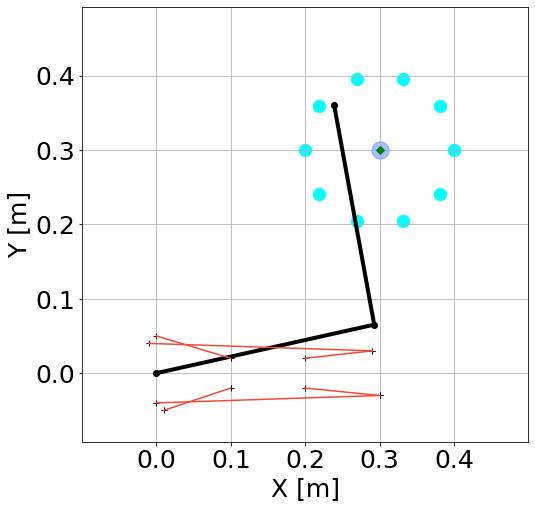

In [538]:
# Single frame
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.1, 0.5])
ax.set_ylim([-.1, 0.5])
ax.tick_params(axis='both', labelsize=tic_s)
ax.set_xlabel('X [m]', fontsize=lab_s)
ax.set_ylabel('Y [m]', fontsize=lab_s)
ax.set_xticks([0., 0.1, 0.2, 0.3, 0.4])
ax.grid()
ax.scatter(targets[:,0], targets[:,1], s=150, c='cyan')
# creating lines and points
line, = ax.plot([], [], 'o-k', lw=4)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
traj, = ax.plot([], [], 'tab:gray', lw=1)
pred_vel, = ax.plot([], [], 'r-o')
ax.scatter([0.3], [0.3], s=300, color=[0.3, 0.5, 1., 0.5])
# preparing a colormap for the tensions
ten_max = np.mean(np.max(ten, axis=1))
ten_min = np.mean(np.min(ten, axis=1))
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
#cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times_l[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times_l[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    traj.set_data([], [])
    pred_vel.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

frame = 0
coord_x = [0, xe[frame], xh[frame]]
coord_y = [0, ye[frame], yh[frame]]
ip_x = ipx[:,frame]
ip_y = ipy[:,frame]
tens = ten[:, frame]
line.set_data(coord_x, coord_y)
points.set_data(ip_x, ip_y)
#traj.set_data(xh[0:frame], yh[0:frame])
#traj.set_data(xh[frame-max(0,frame-fdelay):frame], yh[frame-max(0,frame-fdelay):frame])
if frame > fdelay:
    traj.set_data(xh[frame-fdelay:frame], yh[frame-fdelay:frame])
for i, ml in enumerate(mus_lines):
    idx = 2*i
    ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
    ml.set_color(cmap(150))

# plotting target
#cur_idx = int(cur_time/t_pres) + strt_idx
#cur_idx = int(frame*net.min_delay/t_pres) + strt_idx
cur_idx = int(frame*net.min_delay/t_pres)  # if using new targets
x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
target.set_data([x_coord], [y_coord])

In [539]:
#Animation of the arm and muscles
%matplotlib widget
from matplotlib.animation import FuncAnimation
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.2, lim])
ax.set_ylim([-.2, lim])
ax.grid()
ax.scatter(targets[:,0], targets[:,1], s=150, c='cyan')
# creating lines and points
line, = ax.plot([], [], 'o-k', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
traj, = ax.plot([], [], 'tab:gray', lw=1)
pred_vel, = ax.plot([], [], 'r-o')
ax.scatter([0.3], [0.3], s=200, c='cyan')
# preparing a colormap for the tensions
ten_max = np.mean(np.max(ten, axis=1))
ten_min = np.mean(np.min(ten, axis=1))
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    traj.set_data([], [])
    pred_vel.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    #traj.set_data(xh[0:frame], yh[0:frame])
    #traj.set_data(xh[frame-max(0,frame-fdelay):frame], yh[frame-max(0,frame-fdelay):frame])
    if frame > fdelay:
        traj.set_data(xh[frame-fdelay:frame], yh[frame-fdelay:frame])
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = (frame+start_idx)*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    #cur_idx = int(cur_time/t_pres) + strt_idx
    #cur_idx = int(frame*net.min_delay/t_pres) + strt_idx
    cur_idx = int(frame*net.min_delay/t_pres)  # if using new targets
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    # plotting predicted velocity
    #pred_vel.set_data([xh[frame], xh[frame]+0.3*pred_v[0][frame]], [yh[frame], yh[frame]+0.3*pred_v[1][frame]])
    #pred_vel.set_data([xh[frame], xh[frame]+5.*pred_v2[0][frame]], [yh[frame], yh[frame]+5.*pred_v2[1][frame]])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

#plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [540]:
# alternate way to display the animation
from IPython.display import HTML
#HTML(ani.to_jshtml(fps=20))
HTML(ani.to_html5_video())

IndexError: index 128000 is out of bounds for axis 1 with size 128000

In [ ]:
# save the animation
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Sergio Verduzco'), bitrate=2000)
ani.save('/home/z/Dropbox (OIST)/saves/no_noise_6-22.mp4', writer=writer)

In [ ]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=5*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [ ]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [ ]:
X_init_idx = 0
X_end_idx = X_init_idx + int(1./net.min_delay) # one second
X = data[M[0]:M[6], X_init_idx:X_end_idx].transpose()

In [ ]:
X.shape

In [ ]:
data[M[0]:M[6],X_init_idx:X_end_idx].shape

In [ ]:
# jPCA analysis part 1

import scipy as sp
n = 6 # number of dimensions to consider in M
t_smp = .2 # time to sample M (in seconds)
X_init_idx = 0 # index of time where M sample begins
X_end_idx = X_init_idx + int(t_smp/net.min_delay) # t_smp seconds later

X = data[M[0]:M[n], X_init_idx:X_end_idx].transpose()
t_points = times[X_init_idx:X_end_idx]
# standardize the X data
X = X - np.mean(X)
X = X / np.std(X)

# create the block-matrix version of X
Xtilde = sp.linalg.block_diag(*([X]*n))

# Create the H matrix
n = X.shape[1]
ct = X.shape[0]
L = np.zeros((n,n), dtype=int)
c = 0
for row in range(n):
    for col in range(row+1, n):
        L[row, col] = c
        L[col, row] = c
        c += 1
        
H = np.zeros((n*n, int(0.5*n*(n-1))))
for col in range(n):
    for row in range(n):
        if col > row:
            H[n*col+row, L[col,row]] = 1.
        elif row > col:
            H[n*col+row, L[col,row]] = -1.
            
# Approximate the derivatives of X
Xp = np.zeros_like(X)
t_bit = t_points[1] - t_points[0]
Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

xp = Xp.flatten('F')

kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

# reconstruct the matrix that generated the data
Mstar = np.matmul(H, kstar).reshape(n,n)

In [ ]:
# jPCA analysis part 2

# Next,extract the eigenvalues of M.
eig_vals, eig_vecs = np.linalg.eig(Mstar)
print(Mstar)
print("Eigenvalues: ")
print(eig_vals)
print("Eigenvectors: ")
print(eig_vecs)

eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
ev_sum = eig_vals_norms.sum()/2.
var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
print("Variance percentages by each conjugate eigenvalue pair")
print(var_percentages)

# We obtain the plane of strongest rotations
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)

# project the data onto u1 and u2
u1_proj = (X * u1).sum(axis=1)
u2_proj = (X * u2).sum(axis=1)

In [ ]:
# jPCA analysis part 3

# Sort the data in X according to "preparatory activity"
# to simplify, we use 

In [ ]:
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
print(u1)
print(u2)

In [ ]:
u1_proj.shape

In [ ]:
w_sum = 0.
for syn in net.syns[C[0]]:
    if syn.type is synapse_types.rga_21:
        w_sum += syn.w
        
print(w_sum)

n_syns = 0
for syn_list in net.syns:
    for syn in syn_list:
        n_syns += 1
print(n_syns)
print(len(net.units))

In [ ]:
import cProfile
import pstats
sim_time = 5.
start_time = time.time()
#cProfile.run('times, data, _  = net.run(sim_time)', 't2p3stats')
cProfile.run('times, data, plant_data  = net.flat_run(sim_time)', 'v3ft3p2_stats')
#times, data, _  = net.run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

In [ ]:
p = pstats.Stats('v3ft3p2_stats')
p.sort_stats('cumtime').print_stats(50)

In [ ]:
# restore A__M connections
for mid in M:
    for syn in net.syns[mid]:
        if syn.type is synapse_types.inp_sel:
            syn.w_sum = 2.5
            syn.w_max = 1.2
            syn.l_rate = 10.
            syn.alpha = syn.l_rate * net.min_delay

---